# Step 1: Clone the source code, and install modules

In [ ]:
!git clone https://github.com/SalesforceAIResearch/uni2ts.git
%cd uni2ts
!pip install .


# Step 2: Dataset Generator function

In [ ]:
import pandas as pd
from gluonts.dataset.pandas import PandasDataset
import numpy as np

import pandas as pd
import numpy as np

def generate_df(
    start_date: str, 
    params: list[tuple[float, float, float, float]], 
    std_devs: list[float], 
    polynomial_params: list[tuple[float, ...]] = None
) -> pd.DataFrame:

    # Ensure std_devs and polynomial_params (if provided) match the length of params
    if len(std_devs) != len(params):
        raise ValueError("Length of std_devs must match the length of params.")
    if polynomial_params and len(polynomial_params) != len(params):
        raise ValueError("Length of polynomial_params must match the length of params.")
    
    # Create a date range with hourly increments, starting from start_date, with 10,000 entries
    date_index = pd.date_range(start=start_date, periods=10000, freq='H')
    
    # Calculate the hours passed as an integer sequence from 0 to 9999
    hours_passed = np.arange(10000)
    
    # Create a dictionary to store each column based on the (A, k, p, b) parameters and standard deviation
    data = {}
    
    for i, ((A, k, p, b), std_dev) in enumerate(zip(params, std_devs)):
        column_name = f'column{i+1}'  # Naming columns as column1, column2, etc.
        
        # Generate the sine wave
        sinusoidal_values = A * np.sin(k * hours_passed + p) + b
        
        # Add Gaussian noise
        noise = np.random.normal(0, std_dev, size=hours_passed.shape)
        
        # If polynomial_params is provided, add polynomial values
        if polynomial_params:
            poly_coeffs = polynomial_params[i]
            polynomial_values = sum(c * hours_passed ** (j + 1) for j, c in enumerate(poly_coeffs))
            data[column_name] = sinusoidal_values + noise + polynomial_values
        else:
            # No polynomial, just sine + noise
            data[column_name] = sinusoidal_values + noise
    
    # Create DataFrame with date as index and calculated columns
    df = pd.DataFrame(data, index=date_index)
    return df



In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load both datasets with 'date' as the index column
def load_dataset(file_path):
    df = pd.read_csv(file_path, parse_dates=['date'], index_col='date')
    return df

# Load datasets
etth1_df = load_dataset('/kaggle/input/etthigh/ETTh1.csv')
etth2_df = load_dataset('/kaggle/input/second/ETTh2.csv')

print(etth1_df.head())
print(etth2_df.head())

a, b = 1, -1
etth3_df = a * etth1_df + b * etth2_df
print(etth3_df.head())

# Check if timestamps match between the two datasets
timestamps_match = etth1_df.index.equals(etth2_df.index)

scaler = StandardScaler()

# Apply standardization (excluding the index)
etth1_df[etth1_df.columns] = scaler.fit_transform(etth1_df)
etth2_df[etth2_df.columns] = scaler.fit_transform(etth2_df)
etth3_df[etth3_df.columns] = scaler.fit_transform(etth3_df)



# Step 3: Generate Sine Waves
Each wave is defined by a tuple of amplitude, angular frequency, phase shift, and linear shift.

Also add an appropriate noise with standard deviation

In [ ]:
def generate_random_params(seed: int, num_tuples: int, amp = True, includePhase = True, includeOffset = True):
    # Set random seed for reproducibility
    np.random.seed(seed)
    
    # Define reasonable ranges for each parameter
    if amp:
        amplitude_range = (1, 10)       # Range for amplitude A
    else:
        amplitude_range = (1, 1) 
    frequency_range = (0.02, 0.1)   # Range for angular frequency k
    if includePhase:
        phase_range = (0, 2 * np.pi)    # Range for phase p
    else:
        phase_range = (0, 0)
    if includeOffset:
        offset_range = (-5, 5) 
    else:
        offset_range = (0, 0) # Range for offset b
    std_dev_range = (0.01, 0.2)        # Range for standard deviation of noise

    # Generate random parameters within specified ranges
    params = []
    std_devs = []
    for _ in range(num_tuples):
        A = np.random.uniform(*amplitude_range)
        k = np.random.uniform(*frequency_range)
        p = np.random.uniform(*phase_range)
        b = np.random.uniform(*offset_range)
        sigma = np.random.uniform(*std_dev_range)
        
        params.append((A, k, p, b))
        std_devs.append(sigma)

    # Print the generated parameters in a neat format
    print("Generated Parameters and Standard Deviations:")
    print("Index | Amplitude (A) | Frequency (k) | Phase (p) | Offset (b) | Std Dev (σ)")
    print("-" * 70)
    for i, ((A, k, p, b), sigma) in enumerate(zip(params, std_devs), start=1):
        print(f"{i:<5} | {A:<13.3f} | {k:<13.3f} | {p:<9.3f} | {b:<10.3f} | {sigma:<10.3f}")
    
    return params, std_devs

# Step 4: Use Moirai to make Predictions (512, 96)

In [ ]:
import torch
import matplotlib.pyplot as plt
from gluonts.dataset.split import split
from huggingface_hub import hf_hub_download

from uni2ts.eval_util.plot import plot_single, plot_next_multi
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule

def predict(ds, C = 512, L = 96):  
    # Define Moirai model parameters
    SIZE = "small"  # model size: choose from {'small', 'base', 'large'}
    PDT = L        # prediction length: any positive integer
    CTX = C       # context length: any positive integer
    PSZ = "auto"    # patch size: choose from {"auto", 8, 16, 32, 64, 128}
    BSZ = 32        # batch size: any positive integer
    TEST = 300      # test set length: any positive integer
    
    # Split into train and test sets
    train, test_template = split(ds, offset=-TEST)  # last TEST time steps are test set
    
    # Construct rolling window evaluation
    test_data = test_template.generate_instances(
        prediction_length=PDT,  # number of time steps for each prediction
        windows=TEST // PDT,    # non-overlapping windows
        distance=PDT
    )
    
    model = MoiraiForecast(
        module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.0-R-small"),
        prediction_length=PDT,
        context_length=CTX,
        patch_size=PSZ,
        num_samples=100,
        target_dim=1,
        feat_dynamic_real_dim=ds.num_feat_dynamic_real,
        past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
    )
    
    # Create predictor and forecast
    predictor = model.create_predictor(batch_size=BSZ)
    forecasts = predictor.predict(test_data.input)
    
    input_list = list(test_data.input)
    label_list = list(test_data.label)
    forecast_list = list(forecasts)

    return input_list, label_list, forecast_list


# Step 4: Get the MSE across columns

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

def getError(input_list, label_list, forecast_list, columns):

    input_it = iter(input_list)
    label_it = iter(label_list)
    forecast_it = iter(forecast_list)
    
    total_mse = 0
    total_mae = 0
    cnt = 0
    
    mse_errors = []
    mae_errors = []
    
    for inp, label, forecast in zip(input_it, label_it, forecast_it):
        y_true = np.array(label['target'])      # Actual values
        y_pred = np.array(forecast['median'])   # Forecasted mean values
    
        mse = mean_squared_error(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        
        cnt += 1
        total_mse += mse
        total_mae += mae
        mse_errors.append(mse)
        mae_errors.append(mae)
    
    print("Average MSE:")
    print(total_mse / cnt)
    print("Average MAE")
    print(total_mae / cnt)
    print("")
    
    #Don't forget to change column count here if necessary
    COLUMN_CNT = columns
    block = cnt // COLUMN_CNT

    ret_mse = []
    ret_mae = []
    
    for i in range(0, cnt, block):
        m1 = 0
        m2 = 0
        for j in range(i, i+block):
            m1 += mse_errors[j]
        for j in range(i, i+block):
            m2 += mae_errors[j]
        ret_mse.append(m1/block)
        ret_mae.append(m2/block)

    return ret_mse, ret_mae

# Step 5: Plot the Graphs (For first few instances)

In [ ]:
def plot_graphs(input_list, label_list, forecast_list):
    input_it = iter(input_list)
    label_it = iter(label_list)
    forecast_it = iter(forecast_list)
    
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(25, 10))
    plot_next_multi(
        axes,
        input_it,
        label_it,
        forecast_it,
        context_length=50,
        intervals=(0.5, 0.9),
        dim=None,
        name="pred",
        show_label=True,
    )

In [ ]:
def display(param, mse, mae, ind, std = None, poly = None):
    for i in ind:
        print("Column " + str(i+1) + ":")
        print("Sine parameters, noise, Poly noise")
        print(param[i])
        if std:
            print(std[i])
        if poly:
            print(poly[i])
        print("Errors")
        print(mse[i])
        print(mae[i])
        print("------------------------")

In [ ]:
def analyze(ds, col, C, L, params, stdev = None, poly = None):
    inp, lab, fore = predict(ds, C, L)
    mse, mae = getError(inp, lab, fore, col)
    print("(***************** Worst Case Columns *****************)")
    display(params, mse, mae, np.argsort(mse)[-5:][::-1])
    print("(***************** Best Case Columns *****************)")
    display(params, mse, mae, np.argsort(mse)[:5])
    plot_graphs(inp, lab, fore)



# Experiment 0

In [ ]:
ds = PandasDataset(dict(etth1_df))

inp, lab, fore = predict(ds, 512, 96)
mse, mae = getError(inp, lab, fore, 7)
plot_graphs(inp, lab, fore)

In [ ]:
ds = PandasDataset(dict(etth2_df))

inp, lab, fore = predict(ds, 512, 96)
mse, mae = getError(inp, lab, fore, 7)
plot_graphs(inp, lab, fore)

Average MSE:
0.13683601313820204
Average MAE
0.2707518036940821



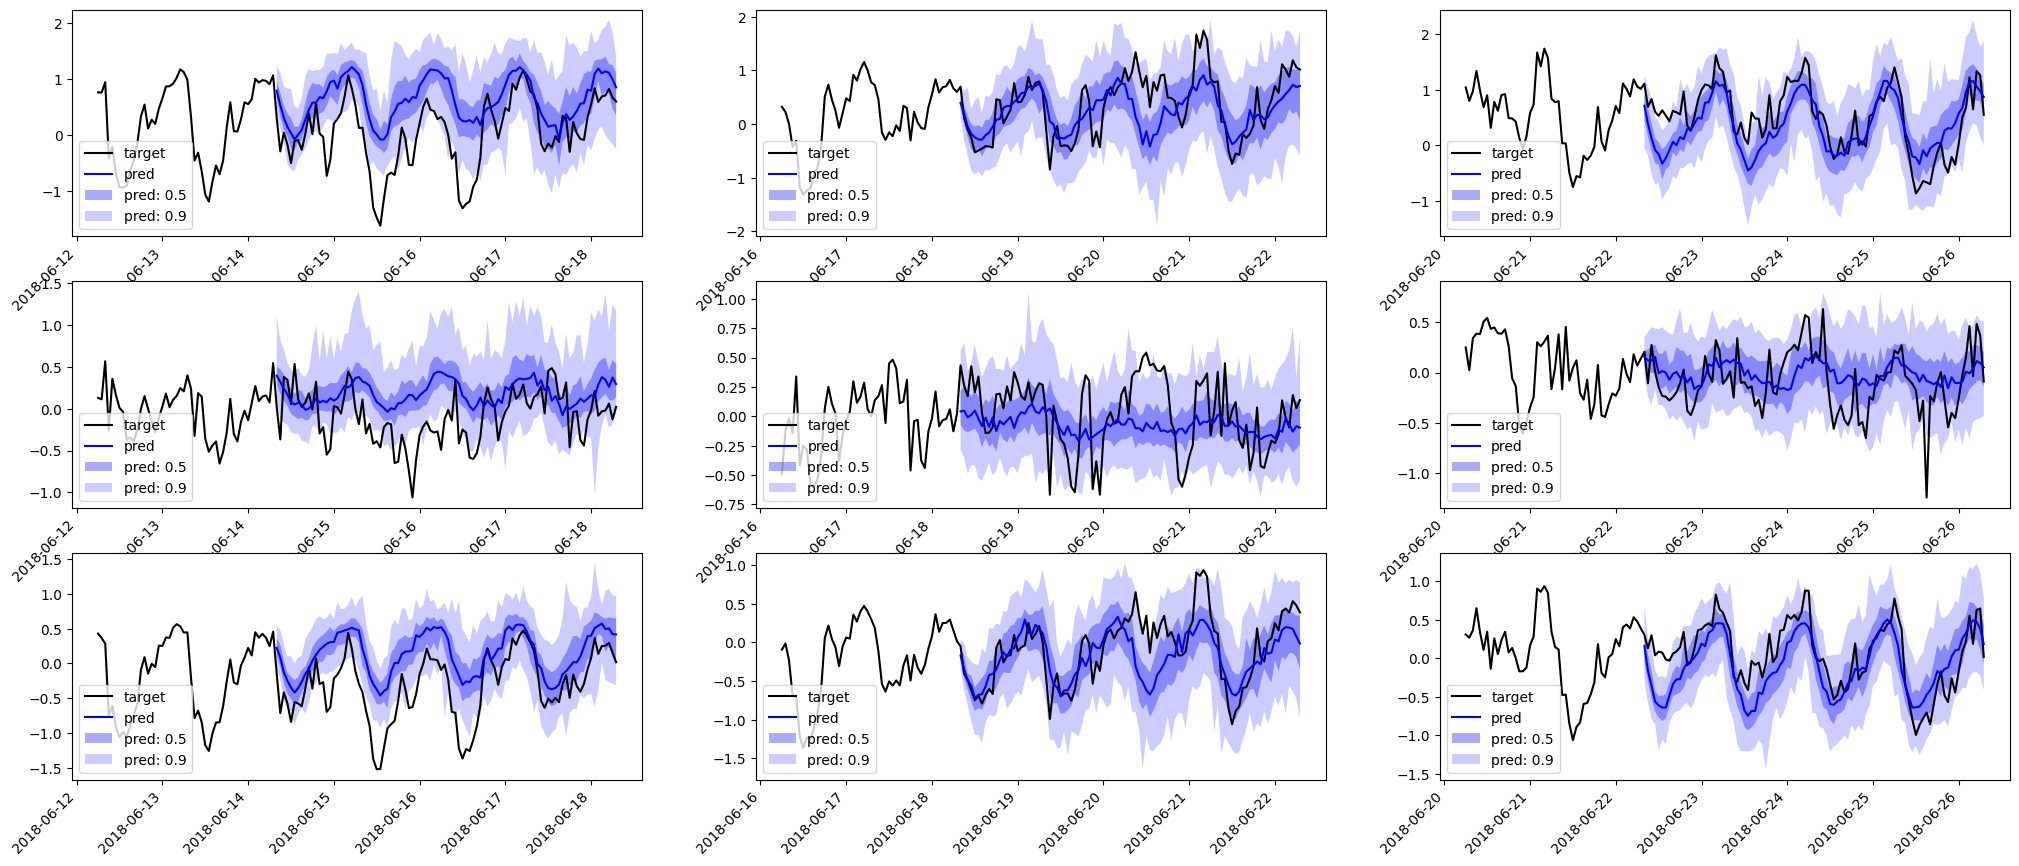

In [30]:
ds = PandasDataset(dict(etth3_df))

inp, lab, fore = predict(ds, 512, 96)
mse, mae = getError(inp, lab, fore, 7)
plot_graphs(inp, lab, fore)


# Experiment 1 (L = 96)

In [23]:
import math

seed = 42 
num_tuples = 30 #Number of sine functions
#params, std_devs = generate_random_params(seed, num_tuples, False, False, False)
#1/(24 * 7), 1/12, 1/6, 1/4, 1/48, 1/24

T = [24, 12]
params = []
for t in T:
    params.append((1, 2 * math.pi / t, 0, 0))


start_date = "2016-07-01 00:00:00"
df = generate_df(start_date, params, [0]* len(T))

print("")
print(df)

ds = PandasDataset(dict(df))


                          column1
2016-07-01 00:00:00  0.000000e+00
2016-07-01 01:00:00  8.660254e-01
2016-07-01 02:00:00  8.660254e-01
2016-07-01 03:00:00  1.224647e-16
2016-07-01 04:00:00 -8.660254e-01
...                           ...
2017-08-21 11:00:00 -8.660254e-01
2017-08-21 12:00:00 -1.814927e-12
2017-08-21 13:00:00  8.660254e-01
2017-08-21 14:00:00  8.660254e-01
2017-08-21 15:00:00  1.484647e-12

[10000 rows x 1 columns]


Average MSE:
0.5641821663957916
Average MAE
0.6488589839345037

(***************** Worst Case Columns *****************)
Column 1:
Sine parameters, noise, Poly noise
(1, 1.0471975511965976, 0, 0)
Errors
0.5641821663957916
0.6488589839345037
------------------------
(***************** Best Case Columns *****************)
Column 1:
Sine parameters, noise, Poly noise
(1, 1.0471975511965976, 0, 0)
Errors
0.5641821663957916
0.6488589839345037
------------------------


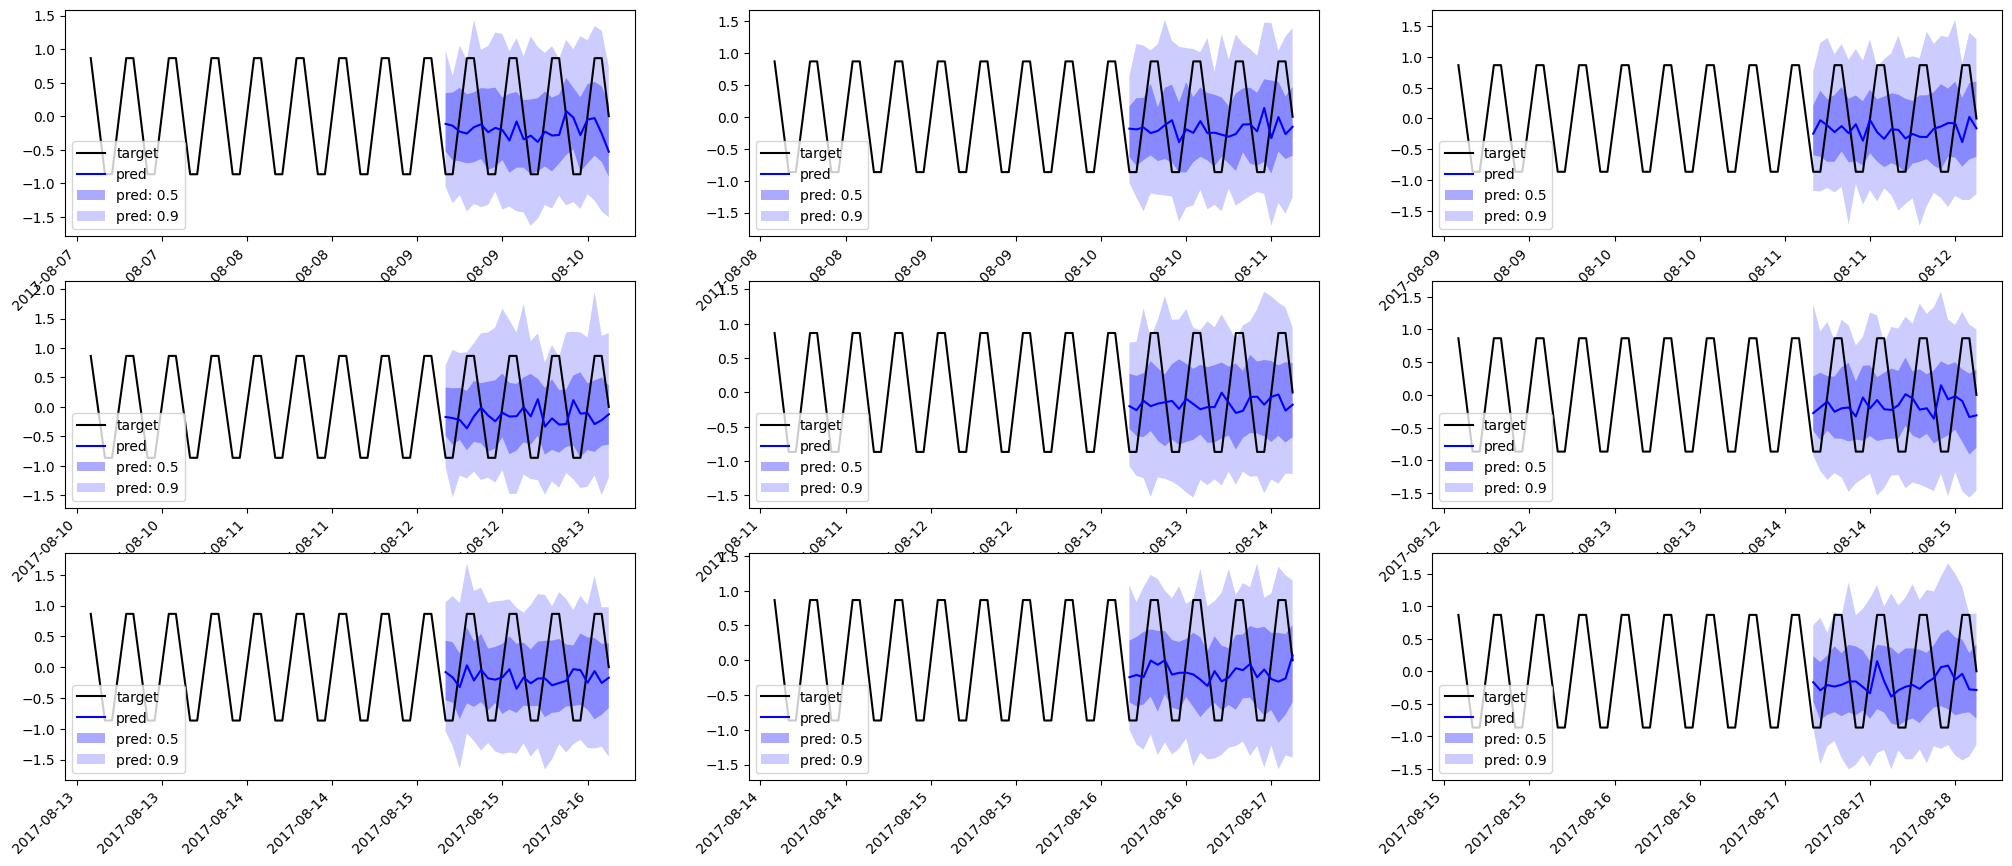

In [24]:
analyze(ds, len(T), 512, 24, params)

# Experiment 2 (L = 192)

Average MSE:
0.5060334198137578
Average MAE
0.5837437455042923

(***************** Worst Case Columns *****************)
Column 22:
Sine parameters, noise, Poly noise
(1.0, 0.052830633842850375, 4.747267812516491, -2.7120183450837754)
0.024626182867470668
Errors
1.0305567680802235
0.8693471379500424
------------------------
Column 7:
Sine parameters, noise, Poly noise
(1.0, 0.033641929894983325, 0.4087312132537349, 4.488855372533333)
0.1934700862841663
Errors
0.7714299609504267
0.7150581745050388
------------------------
Column 6:
Sine parameters, noise, Poly noise
(1.0, 0.035973902572668776, 3.23103026788615, 0.9241456886204249)
0.01882557841679957
Errors
0.7239525008158975
0.6473910923264523
------------------------
Column 19:
Sine parameters, noise, Poly noise
(1.0, 0.0770595829778396, 4.780153439391597, 0.6127719756949626)
0.1564837641913666
Errors
0.7237597854551238
0.7052629010247987
------------------------
Column 27:
Sine parameters, noise, Poly noise
(1.0, 0.03776862483765842,

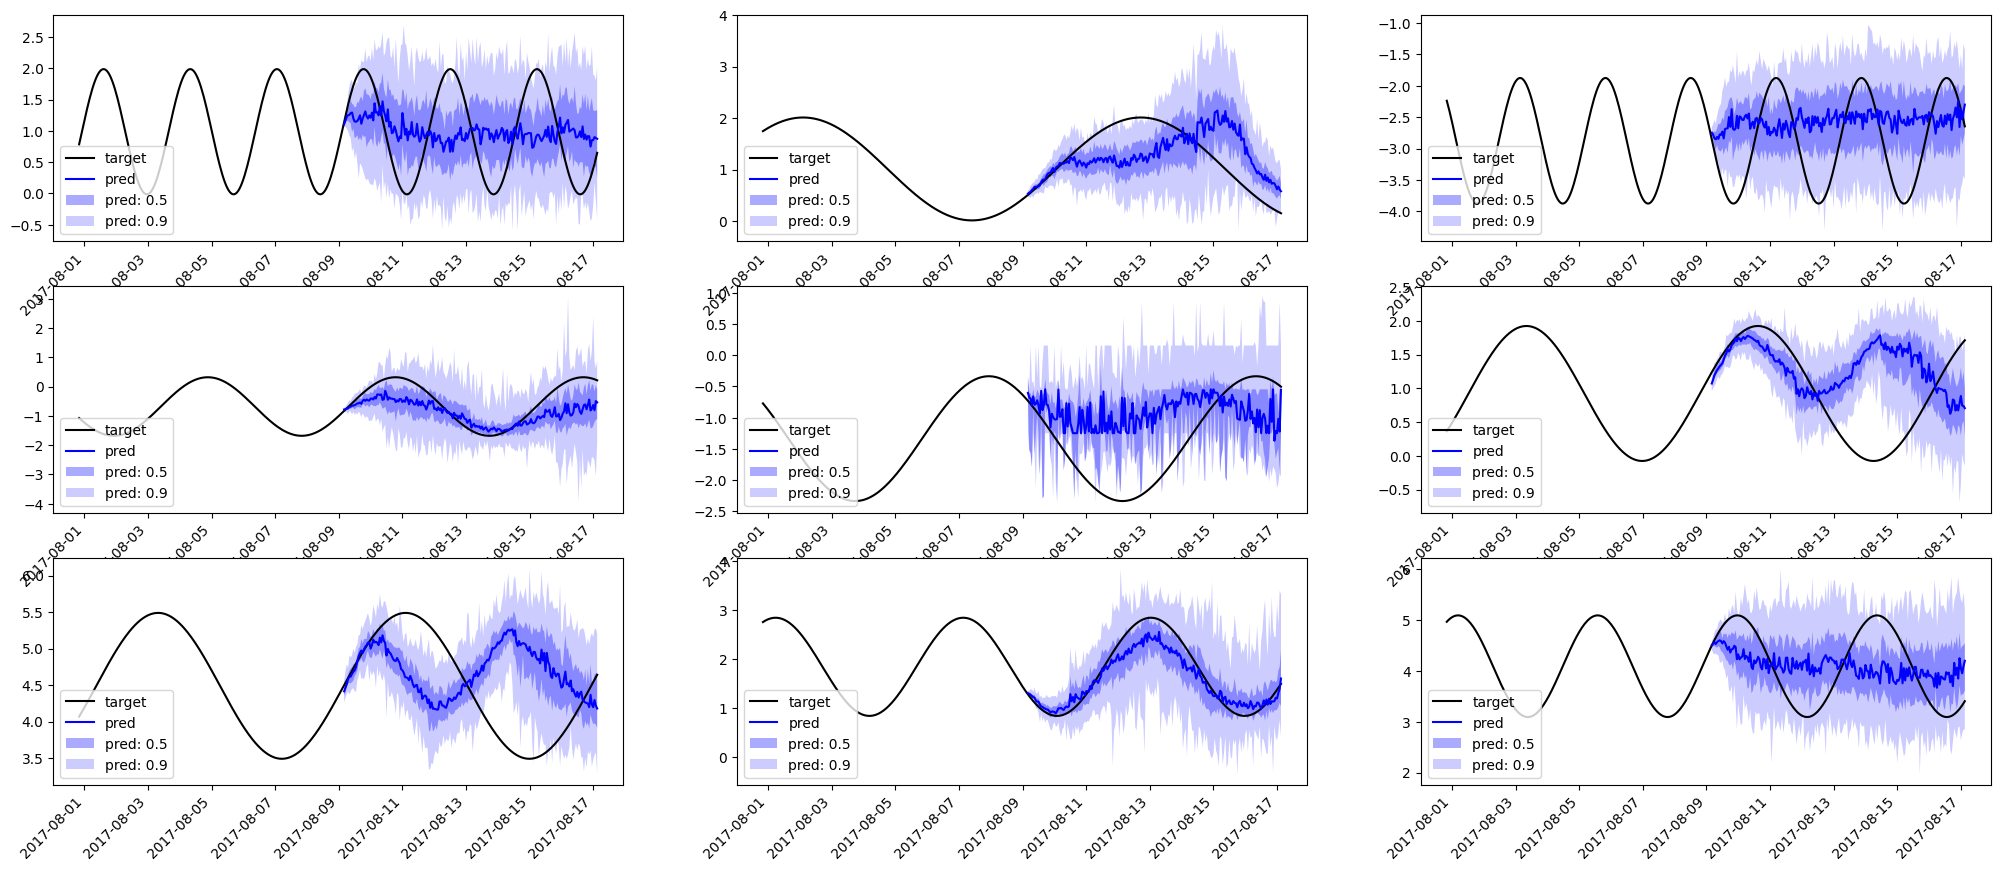

In [20]:
analyze(ds, 30, 512, 192, params)

# Experiment 3 (Specific Time Periods)

Average MSE:
0.19829044984127944
Average MAE
0.26182916352162

(***************** Worst Case Columns *****************)
Column 3:
Sine parameters, noise, Poly noise
(1.0, 0.032724923474893676, 0.0, 0.0)
0.04454674376934912
Errors
0.855459903280383
0.8025259436624342
------------------------
Column 5:
Sine parameters, noise, Poly noise
(1.0, 0.016362461737446838, 0.0, 0.0)
0.09665329700123683
Errors
0.07328529432861551
0.18598268122283168
------------------------
Column 1:
Sine parameters, noise, Poly noise
(1.0, 0.06544984694978735, 0.0, 0.0)
0.039643541684062936
Errors
0.032065555342600145
0.14704141324628606
------------------------
Column 2:
Sine parameters, noise, Poly noise
(1.0, 0.1308996938995747, 0.0, 0.0)
0.14453378978124864
Errors
0.02831700518258631
0.13896395435212847
------------------------
Column 4:
Sine parameters, noise, Poly noise
(1.0, 0.2617993877991494, 0.0, 0.0)
0.06533353663762796
Errors
0.0023244910722120334
0.03463182512441975
------------------------
(********

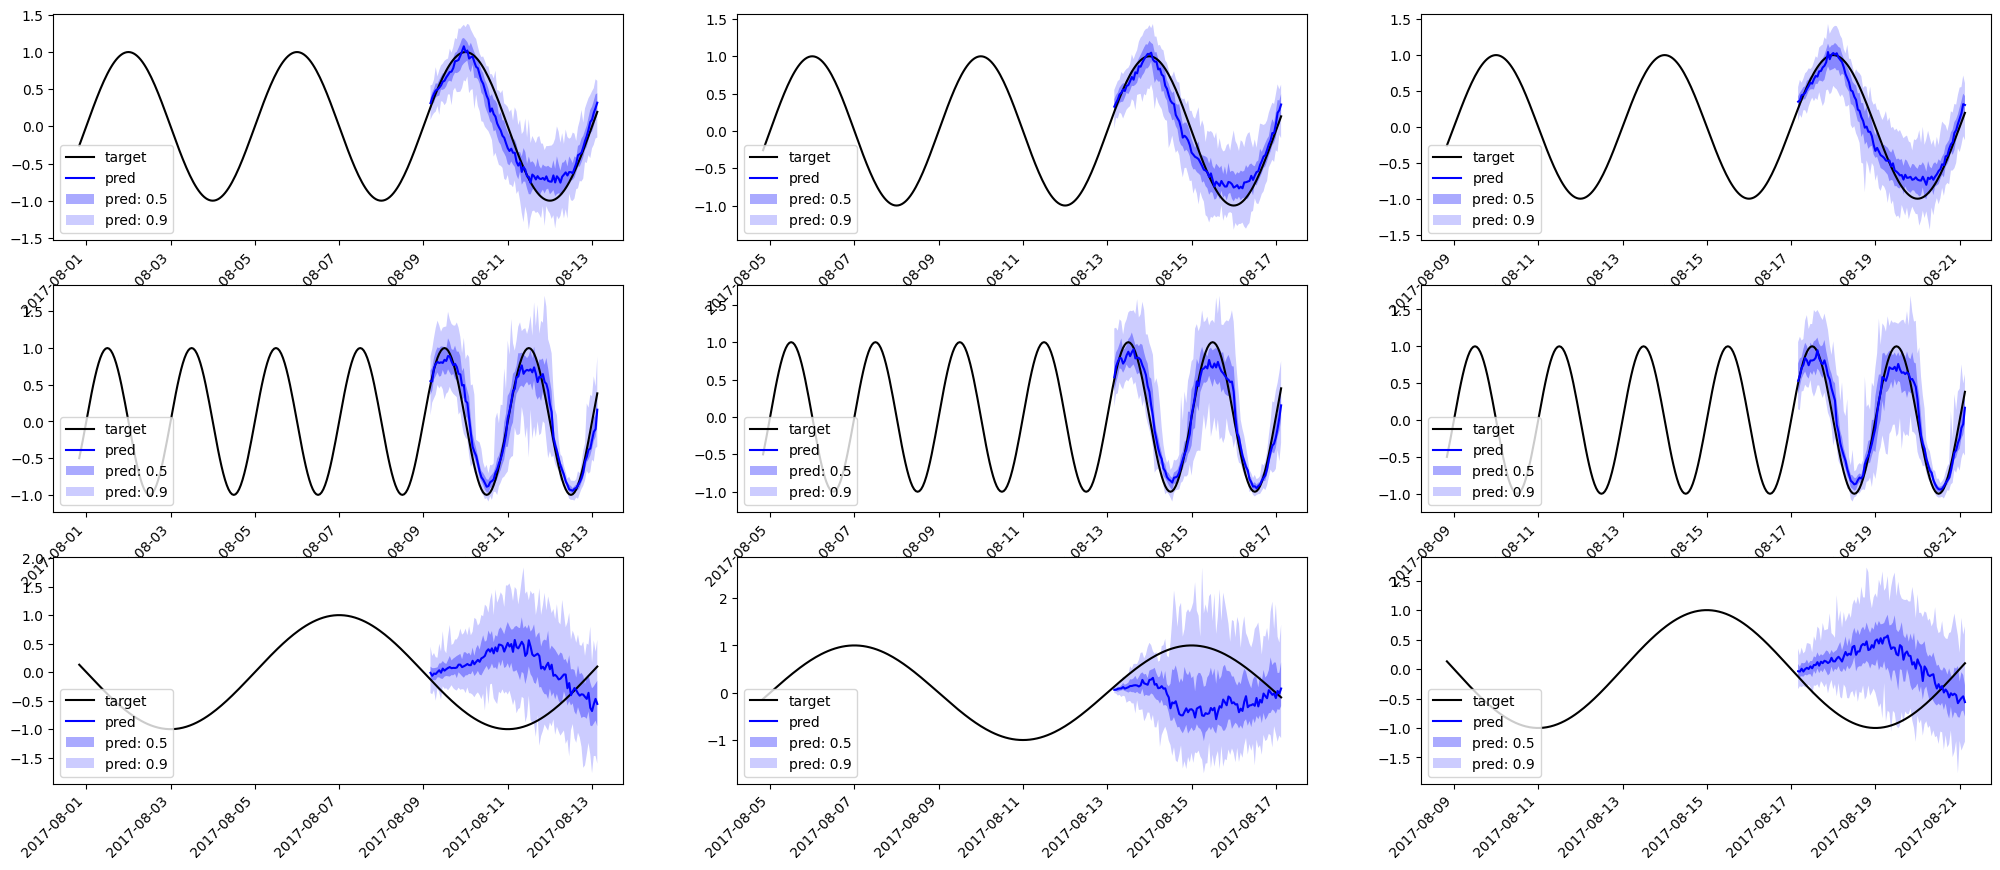

In [21]:
import math 

base = 2 * math.pi / 96
params = [(1.0, base, 0.0, 0.0), (1.0, base * 2, 0.0, 0.0), (1.0, base / 2, 0.0, 0.0), (1.0, base * 4, 0.0, 0.0),(1.0, base / 4, 0.0, 0.0)]

start_date = "2016-07-01 00:00:00"
df = generate_df(start_date, params, [0]*5)

ds = PandasDataset(dict(df))

analyze(ds, 5, 512, 96, params)


Average MSE:
0.339542261141025
Average MAE
0.36383418802760026

(***************** Worst Case Columns *****************)
Column 3:
Sine parameters, noise, Poly noise
(1.0, 0.032724923474893676, 2.5, 0.0)
0.04454674376934912
Errors
1.3017210684268514
0.9732315770401523
------------------------
Column 5:
Sine parameters, noise, Poly noise
(1.0, 0.016362461737446838, 2.5, 0.0)
0.09665329700123683
Errors
0.17160156979807062
0.30803330540290613
------------------------
Column 1:
Sine parameters, noise, Poly noise
(1.0, 0.06544984694978735, 2.5, 0.0)
0.039643541684062936
Errors
0.16450651791226187
0.3047486856693909
------------------------
Column 2:
Sine parameters, noise, Poly noise
(1.0, 0.1308996938995747, 2.5, 0.0)
0.14453378978124864
Errors
0.05805943403890516
0.19810143474710074
------------------------
Column 4:
Sine parameters, noise, Poly noise
(1.0, 0.2617993877991494, 2.5, 0.0)
0.06533353663762796
Errors
0.0018227155290363077
0.03505593727845122
------------------------
(********

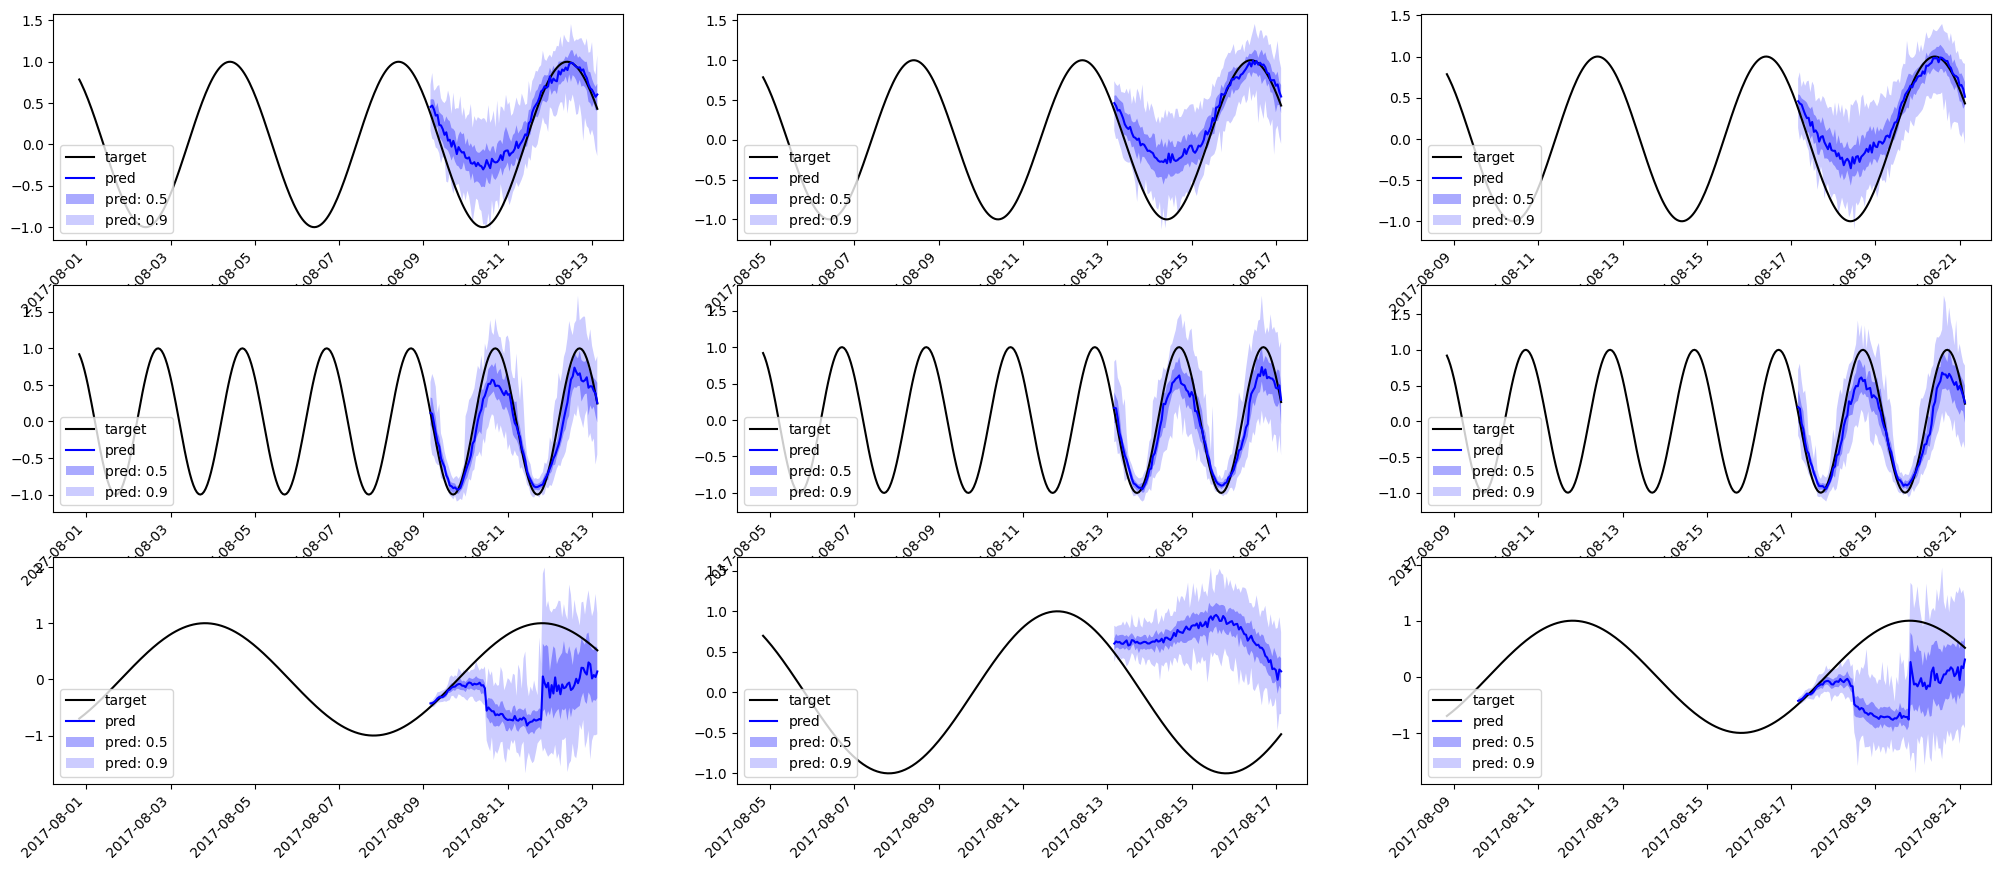

In [22]:
import math 

base = 2 * math.pi / 96
params = [(1.0, base, 2.5, 0.0), (1.0, base * 2, 2.5, 0.0), (1.0, base / 2, 2.5, 0.0), (1.0, base * 4, 2.5, 0.0),(1.0, base / 4, 2.5, 0.0)]

start_date = "2016-07-01 00:00:00"
df = generate_df(start_date, params, [0]*5)

ds = PandasDataset(dict(df))

analyze(ds, 5, 512, 96, params)

Average MSE:
0.19727232232744676
Average MAE
0.2619529080759821

(***************** Worst Case Columns *****************)
Column 3:
Sine parameters, noise, Poly noise
(1.0, 0.032724923474893676, 0.0, 5.0)
0.04454674376934912
Errors
0.8496260568840244
0.8007297555057383
------------------------
Column 5:
Sine parameters, noise, Poly noise
(1.0, 0.016362461737446838, 0.0, 5.0)
0.09665329700123683
Errors
0.07274801245666863
0.18461637129944494
------------------------
Column 1:
Sine parameters, noise, Poly noise
(1.0, 0.06544984694978735, 0.0, 5.0)
0.039643541684062936
Errors
0.03217278155221274
0.14753284660964675
------------------------
Column 2:
Sine parameters, noise, Poly noise
(1.0, 0.1308996938995747, 0.0, 5.0)
0.14453378978124864
Errors
0.029266444098577333
0.1409277332686607
------------------------
Column 4:
Sine parameters, noise, Poly noise
(1.0, 0.2617993877991494, 0.0, 5.0)
0.06533353663762796
Errors
0.0025483166457507833
0.03595783369641994
------------------------
(******

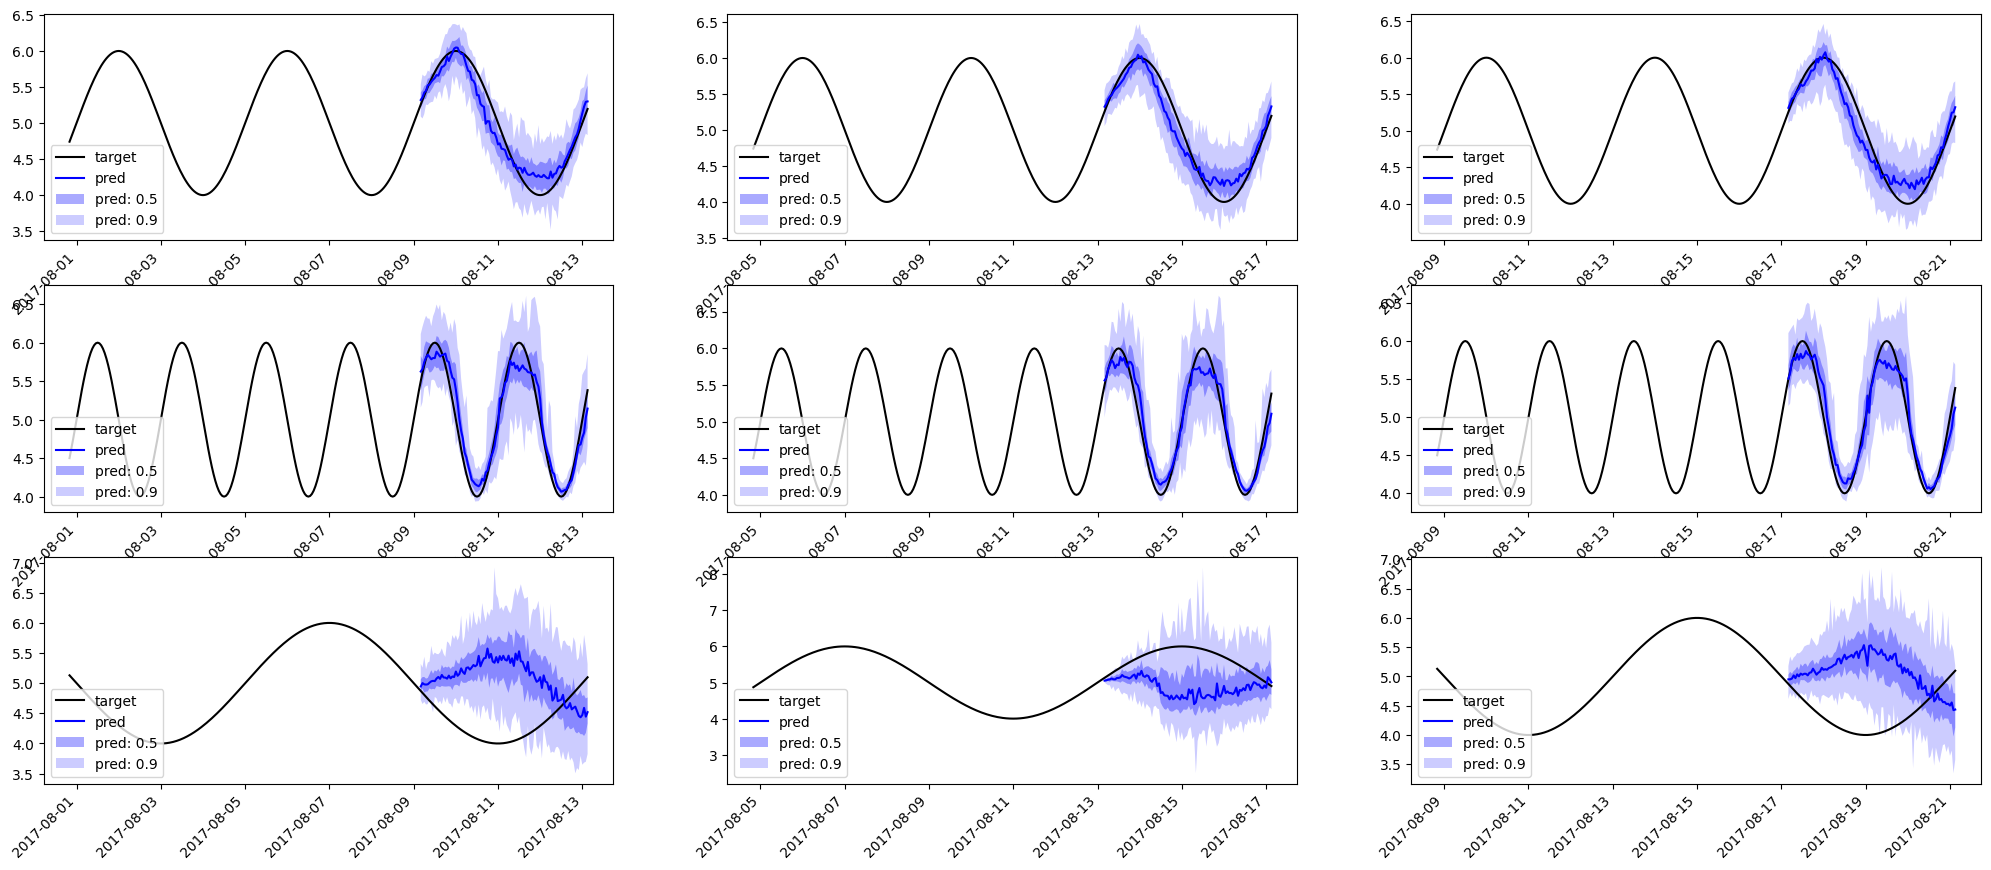

In [23]:
import math 

base = 2 * math.pi / 96
params = [(1.0, base, 0.0, 5.0), (1.0, base * 2, 0.0, 5.0), (1.0, base / 2, 0.0, 5.0), (1.0, base * 4, 0.0, 5.0),(1.0, base / 4, 0.0, 5.0)]

start_date = "2016-07-01 00:00:00"
df = generate_df(start_date, params, [0]*5)

ds = PandasDataset(dict(df))

analyze(ds, 5, 512, 96, params)

Average MSE:
0.7173403665121528
Average MAE
0.7143935738559436

(***************** Worst Case Columns *****************)
Column 5:
Sine parameters, noise, Poly noise
(1.0, 0.032724923474893676, 6.283185307179586, 0)
0.09665329700123683
Errors
0.8608074923110859
0.8067877154380162
------------------------
Column 1:
Sine parameters, noise, Poly noise
(1.0, 0.032724923474893676, 0.0, 0)
0.039643541684062936
Errors
0.8505378290369953
0.8007113297252224
------------------------
Column 3:
Sine parameters, noise, Poly noise
(1.0, 0.032724923474893676, 3.141592653589793, 0)
0.04454674376934912
Errors
0.843482645802463
0.7924207654105415
------------------------
Column 4:
Sine parameters, noise, Poly noise
(1.0, 0.032724923474893676, 4.71238898038469, 0)
0.06533353663762796
Errors
0.5312818390428321
0.5890910748003743
------------------------
Column 2:
Sine parameters, noise, Poly noise
(1.0, 0.032724923474893676, 1.5707963267948966, 0)
0.14453378978124864
Errors
0.5005920263673885
0.5829569839

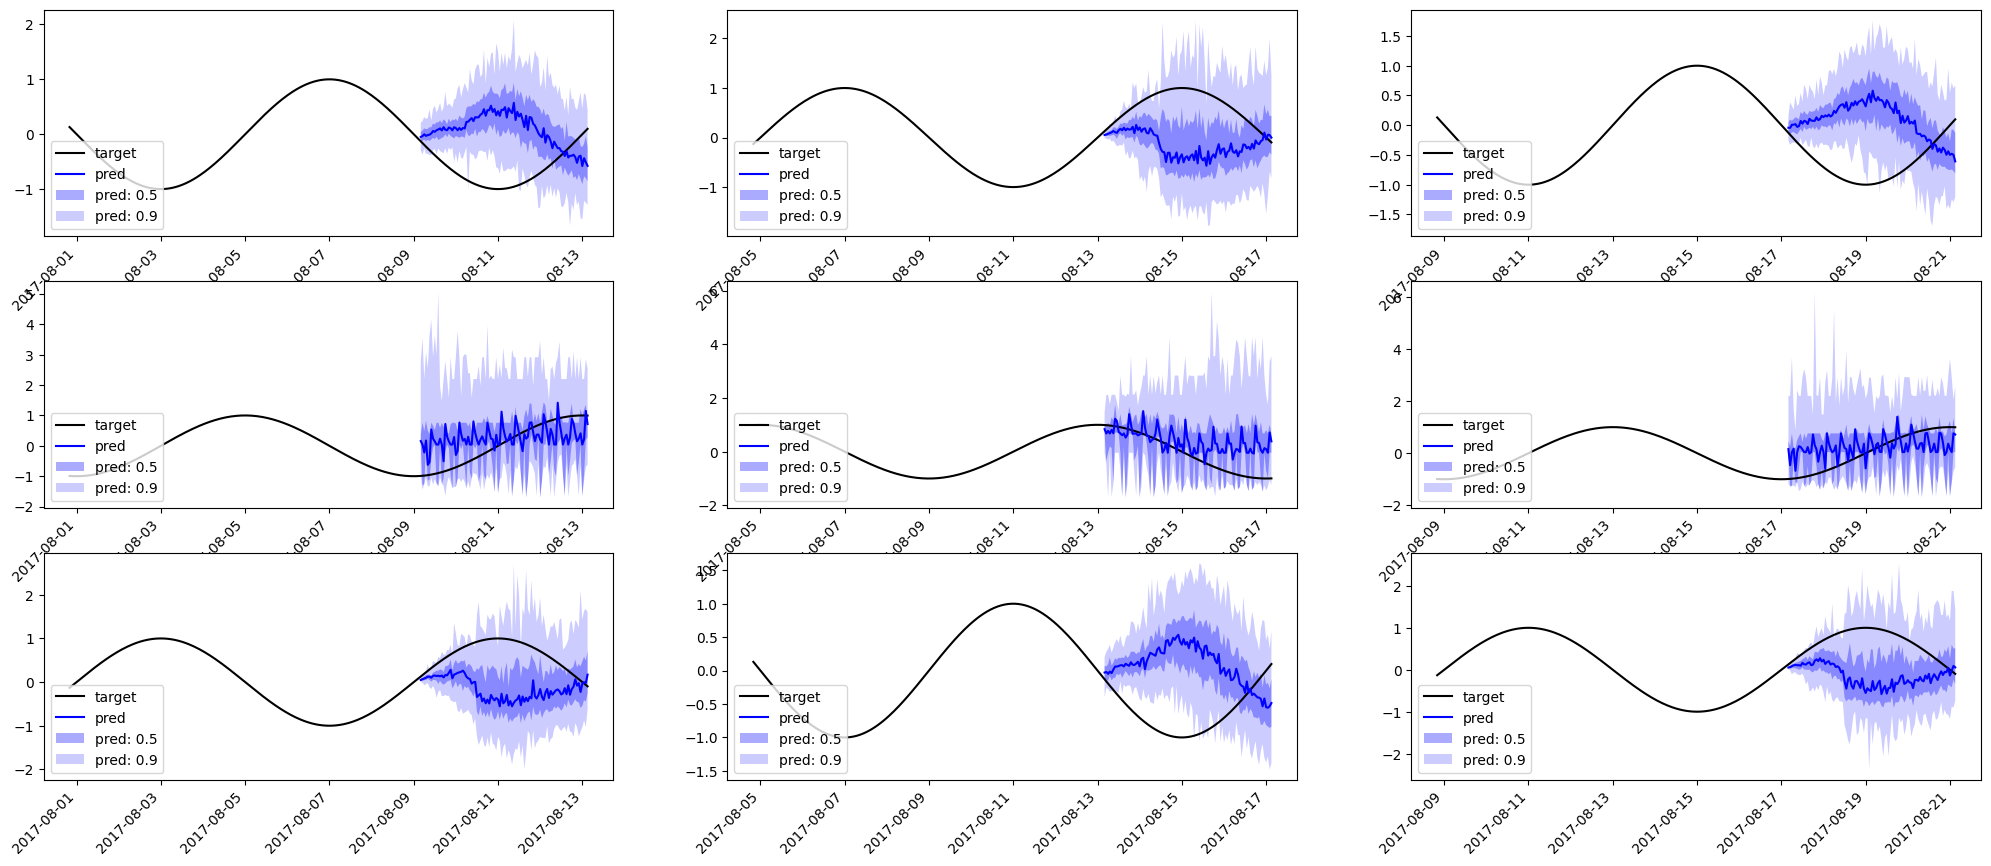

In [24]:
import math 

base = 2 * math.pi / 96
params = [(1.0, base/2, 0.0, 0), (1.0, base/2, math.pi / 2, 0), (1.0, base/2, math.pi, 0), (1.0, base/2, 3 * math.pi / 2, 0),(1.0, base/2, 2 * math.pi, 0)]

start_date = "2016-07-01 00:00:00"
df = generate_df(start_date, params, [0]*5)

ds = PandasDataset(dict(df))

analyze(ds, 5, 512, 96, params)

Average MSE:
0.4965815727199493
Average MAE
0.567760819400839

(***************** Worst Case Columns *****************)
Column 5:
Sine parameters, noise, Poly noise
(1.0, 0.09817477042468103, 0.0, 0)
0.09665329700123683
Errors
0.8169304698800509
0.7807506635832281
------------------------
Column 4:
Sine parameters, noise, Poly noise
(1.0, 0.09162978572970229, 0.0, 0)
0.06533353663762796
Errors
0.5449399634256161
0.6391585343436624
------------------------
Column 1:
Sine parameters, noise, Poly noise
(1.0, 0.0719948316447661, 0.0, 0)
0.039643541684062936
Errors
0.5128663805432591
0.5974420581096261
------------------------
Column 2:
Sine parameters, noise, Poly noise
(1.0, 0.07853981633974481, 0.0, 0)
0.14453378978124864
Errors
0.48050281070134665
0.5512336713242435
------------------------
Column 3:
Sine parameters, noise, Poly noise
(1.0, 0.08508480103472356, 0.0, 0)
0.04454674376934912
Errors
0.12766823904947375
0.2702191696434348
------------------------
(***************** Best Case

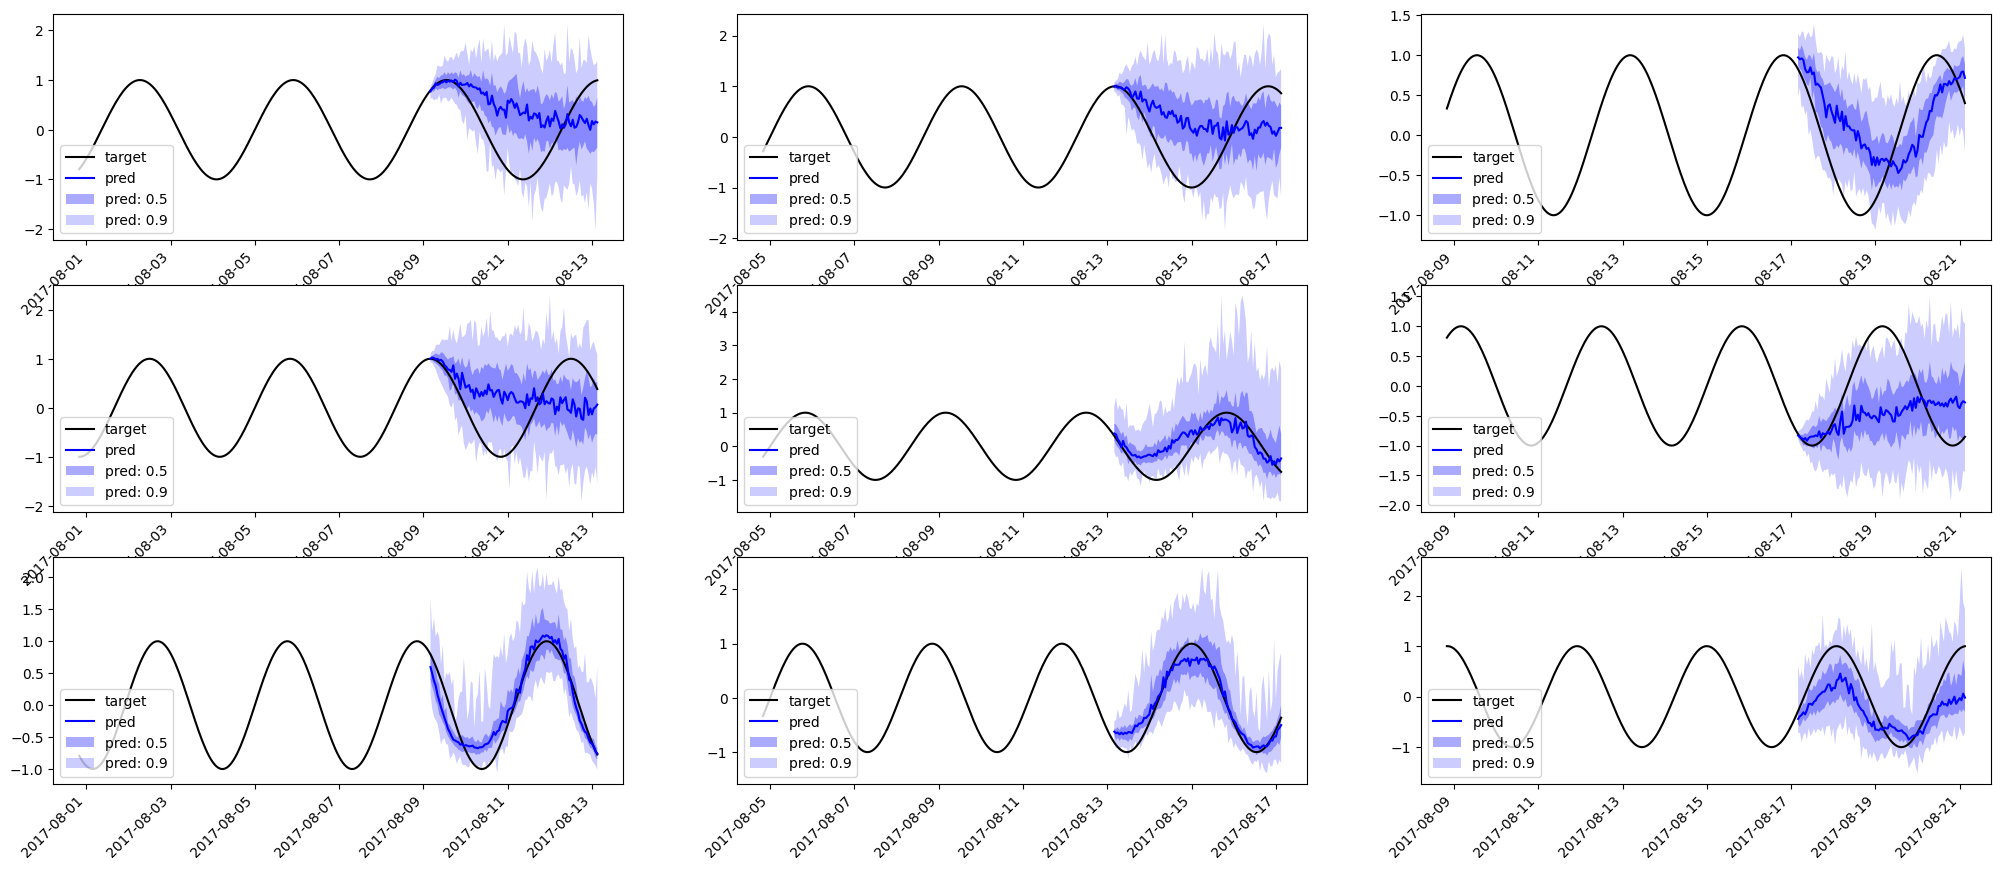

In [25]:
import math 

base = 2 * math.pi / 96
params = [(1.0, base * 1.1, 0.0, 0), (1.0, base * 1.2, 0.0, 0), (1.0, base * 1.3, 0.0, 0), (1.0, base * 1.4, 0.0, 0),(1.0, base * 1.5, 0.0, 0)]

start_date = "2016-07-01 00:00:00"
df = generate_df(start_date, params, [0]*5)

ds = PandasDataset(dict(df))

analyze(ds, 5, 512, 96, params)

Average MSE:
0.3533188173779272
Average MAE
0.45748674447813187

(***************** Worst Case Columns *****************)
Column 4:
Sine parameters, noise, Poly noise
(1.0, 0.3490658503988659, 0.0, 0.0)
0.06533353663762796
Errors
0.5736075478767428
0.6669204300651653
------------------------
Column 3:
Sine parameters, noise, Poly noise
(1.0, 0.04363323129985824, 0.0, 0.0)
0.04454674376934912
Errors
0.4911495435439861
0.5308777637896251
------------------------
Column 5:
Sine parameters, noise, Poly noise
(1.0, 0.02181661564992912, 0.0, 0.0)
0.09665329700123683
Errors
0.3026445035084197
0.3663786732748204
------------------------
Column 2:
Sine parameters, noise, Poly noise
(1.0, 0.17453292519943295, 0.0, 0.0)
0.14453378978124864
Errors
0.2659282943913166
0.41195534479179435
------------------------
Column 1:
Sine parameters, noise, Poly noise
(1.0, 0.08726646259971647, 0.0, 0.0)
0.039643541684062936
Errors
0.13326419756917074
0.31130151046925425
------------------------
(**************

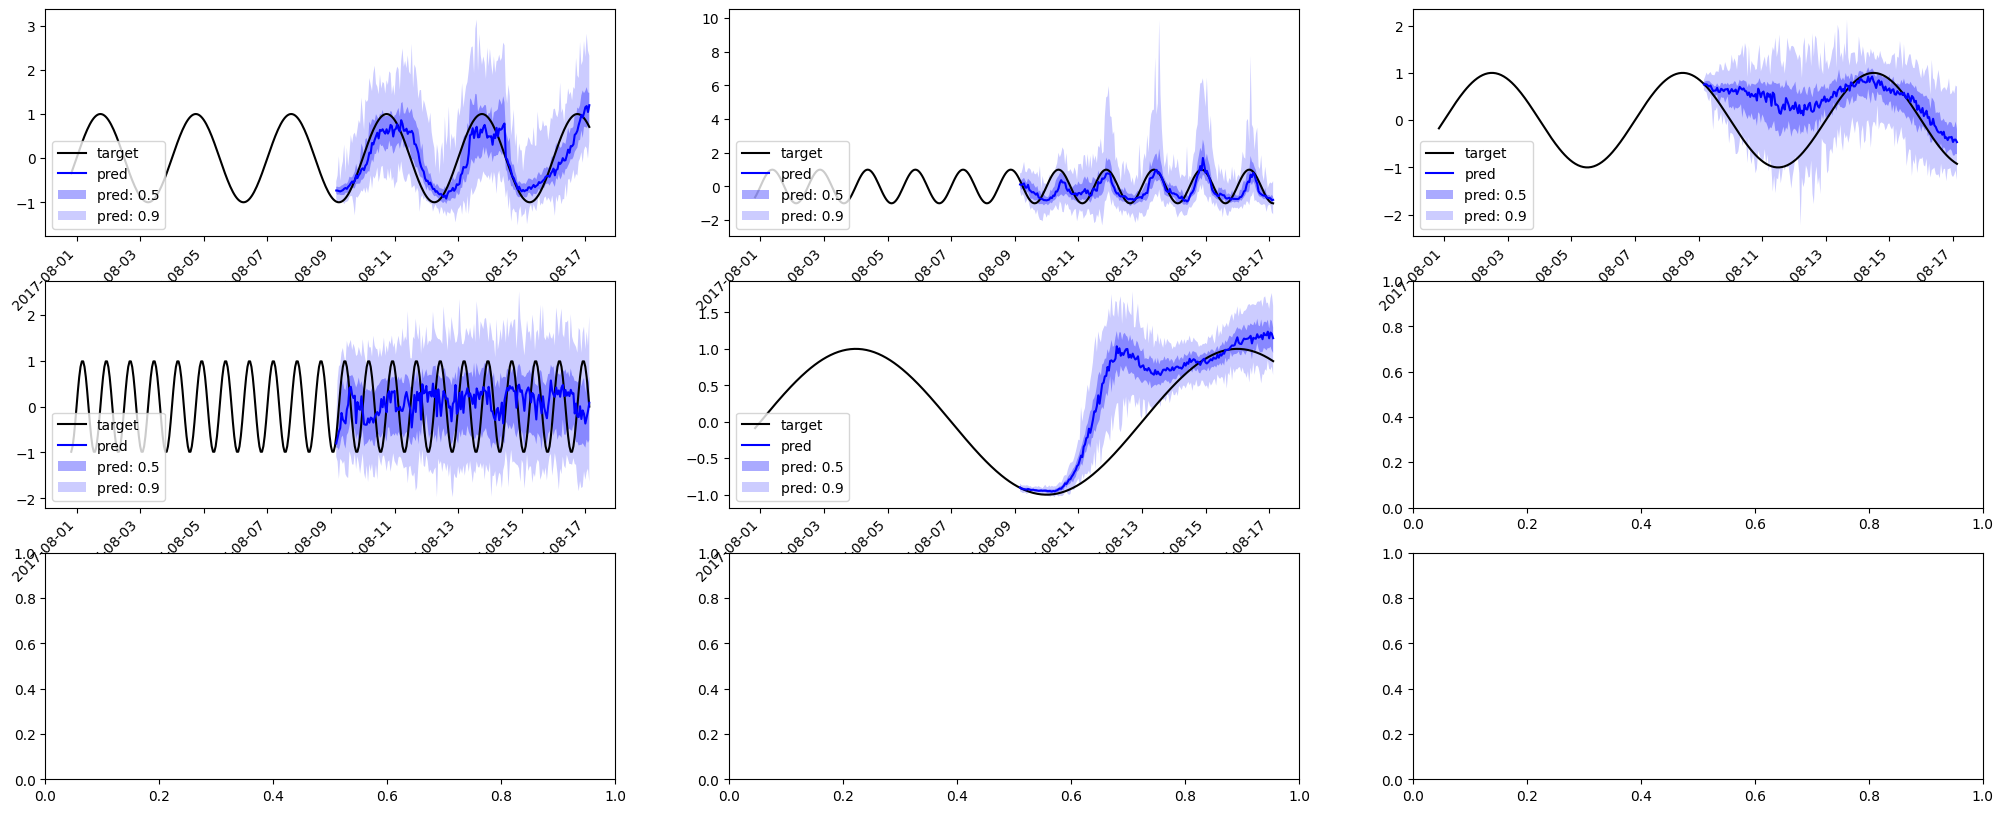

In [26]:
import math 

base = 2 * math.pi / 72
params = [(1.0, base, 0.0, 0.0), (1.0, base * 2, 0.0, 0.0), (1.0, base / 2, 0.0, 0.0), (1.0, base * 4, 0.0, 0.0),(1.0, base / 4, 0.0, 0.0)]

start_date = "2016-07-01 00:00:00"
df = generate_df(start_date, params, [0]*5)

ds = PandasDataset(dict(df))

analyze(ds, 5, 512, 192, params)

# Experiment 4 (Noise)

                      column1   column2   column3   column4   column5  \
2016-07-01 00:00:00 -0.233974  0.183984 -0.518112 -0.501780  0.565421   
2016-07-01 01:00:00 -0.342075 -0.096998 -0.402653 -0.735504 -0.248352   
2016-07-01 02:00:00 -0.496569 -0.426469 -0.836862 -0.656545 -0.976962   
2016-07-01 03:00:00 -0.323191 -0.324265 -0.496489 -0.717106 -1.075458   
2016-07-01 04:00:00 -0.432504 -0.392005 -0.203711 -0.258092 -0.359642   
...                       ...       ...       ...       ...       ...   
2017-08-21 11:00:00 -1.974956 -1.866105 -2.259883 -2.128682 -1.927306   
2017-08-21 12:00:00 -2.143099 -1.969047 -1.876109 -1.702971 -1.139816   
2017-08-21 13:00:00 -2.032914 -1.839199 -2.156596 -1.902756 -2.869043   
2017-08-21 14:00:00 -1.995902 -2.144730 -2.130785 -2.186410 -2.162446   
2017-08-21 15:00:00 -2.049702 -1.801632 -2.092579 -1.494415 -1.727293   

                      column6   column7   column8   column9  column10  
2016-07-01 00:00:00 -0.349490  0.213615 -0.554668  

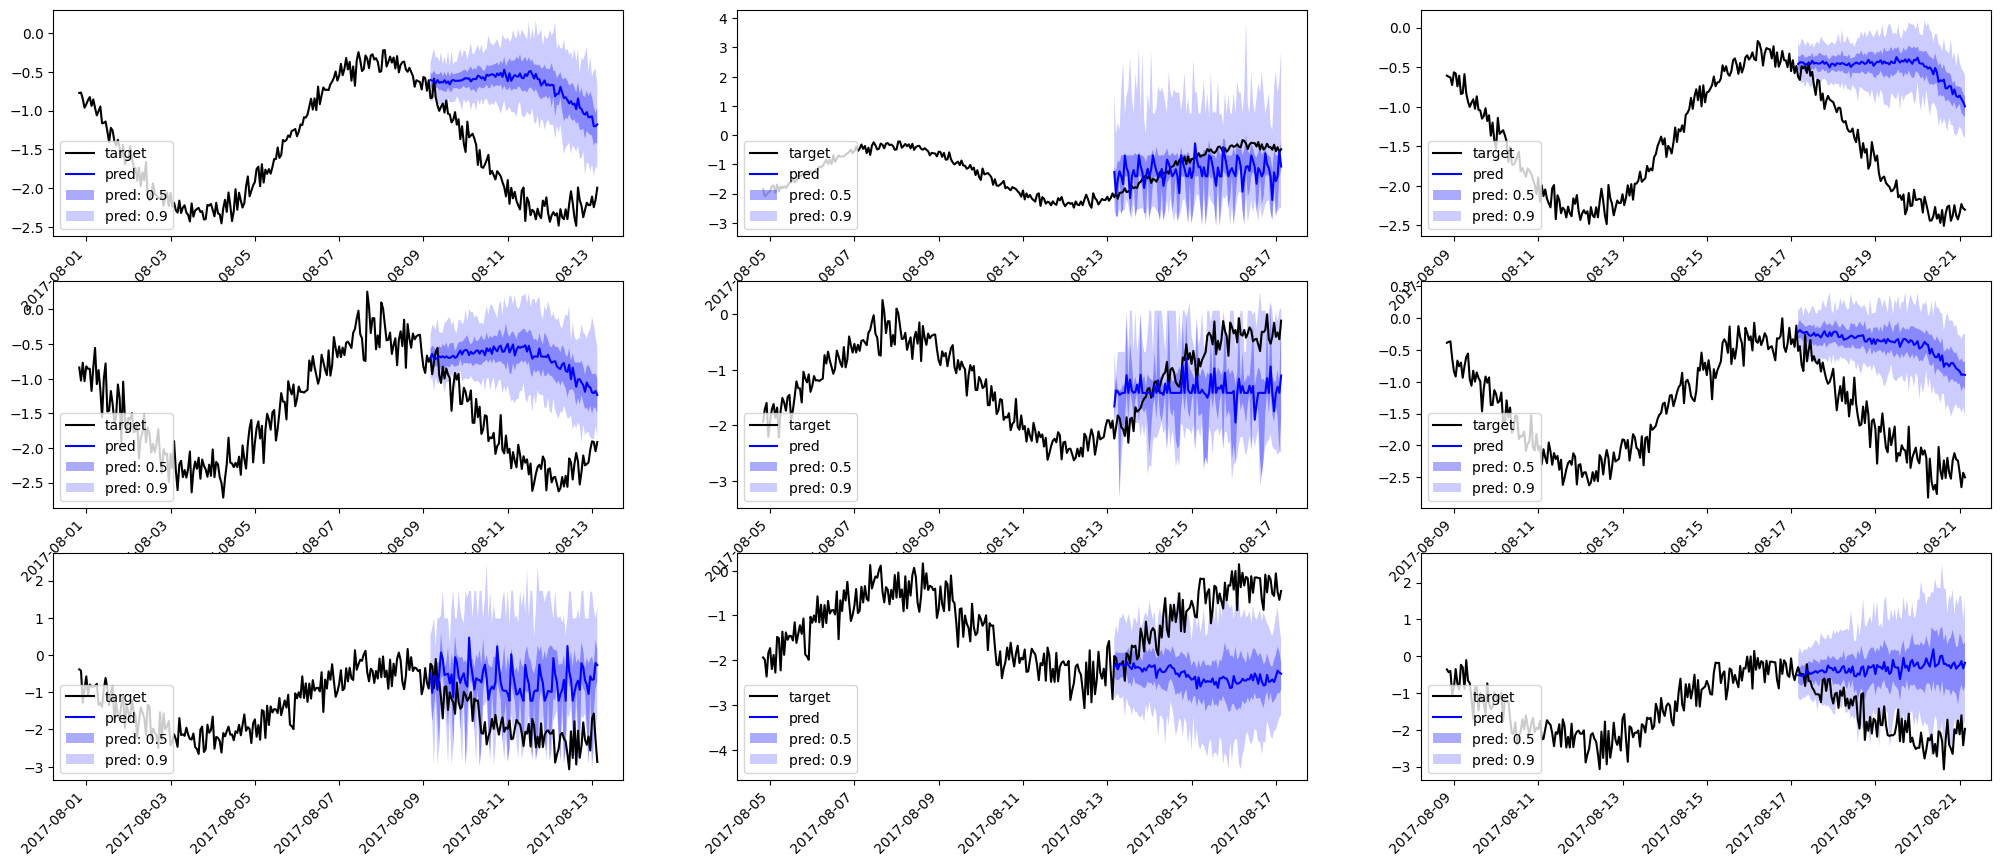

In [27]:
params = [(1.0, 0.03115950885216335, 1.8355989632476268, -1.336381567063083)] * 10
stdev = [0.1*i for i in range(1, 11)]

start_date = "2016-07-01 00:00:00"
df = generate_df(start_date, params, stdev)
print(df)

ds = PandasDataset(dict(df))

analyze(ds, 10, 512, 96, params, stdev)

# Experiment 5 (Linear)

In [28]:
def generate_polynomials(degree: int, num_polynomials: int, std_dev: float, seed: int = 42) -> list:
    """
    Generates a list of polynomials with coefficients sampled from a normal distribution.
    
    Args:
    - degree (int): Degree of the polynomials.
    - num_polynomials (int): Number of polynomials to generate.
    - std_dev (float): Standard deviation for the normal distribution of coefficients.
    - seed (int): Seed for reproducibility.
    
    Returns:
    - list of tuples: Each tuple represents the coefficients of a polynomial.
    """
    # Set the seed for reproducibility
    np.random.seed(seed)
    
    # Generate the polynomials
    polynomials = []
    for _ in range(num_polynomials):
        # Sample coefficients from a normal distribution with mean 0 and specified std_dev
        coeffs = tuple(np.random.normal(0, std_dev, degree))
        polynomials.append(coeffs)
    
    return polynomials

# Example usage
degree = 1
num_polynomials = 10
std_dev = 0.01  # Adjust the standard deviation as needed

polynomials = generate_polynomials(degree, num_polynomials, std_dev)
print("Generated Polynomials:", polynomials)

Generated Polynomials: [(0.004967141530112327,), (-0.0013826430117118466,), (0.006476885381006925,), (0.015230298564080254,), (-0.0023415337472333596,), (-0.0023413695694918055,), (0.015792128155073915,), (0.007674347291529088,), (-0.004694743859349522,), (0.005425600435859647,)]


In [29]:
params = [(1.0, 0.04436910153386965, 0.6136919916460806, 1.8423302651215687)] * 10  # Sine function parameters: A, k, p, b
stdev = [0.1] * 10

degree = 1                           # Polynomial degree
seed = 42                            # Seed for reproducibility

poly = generate_polynomials(1, 10, 0.01, seed)
df = generate_df(start_date, params, stdev, poly)


print(df)
ds = PandasDataset(dict(df))

                       column1    column2    column3     column4    column5  \
2016-07-01 00:00:00   2.371878   2.510414   2.498515    2.391290   2.313891   
2016-07-01 01:00:00   2.412308   2.537673   2.505201    2.296870   2.653961   
2016-07-01 02:00:00   2.522535   2.354060   2.442736    2.403592   2.506925   
2016-07-01 03:00:00   2.345197   2.470881   2.436419    2.527021   2.514954   
2016-07-01 04:00:00   2.400882   2.630274   2.631710    2.305104   2.501501   
...                        ...        ...        ...         ...        ...   
2017-08-21 11:00:00  50.512448 -12.941963  65.748856  153.163911 -22.359503   
2017-08-21 12:00:00  50.676094 -13.096343  65.549479  152.984745 -22.503246   
2017-08-21 13:00:00  50.486111 -12.758655  65.620017  153.269118 -22.488008   
2017-08-21 14:00:00  50.469622 -12.953916  65.656441  153.290921 -22.369178   
2017-08-21 15:00:00  50.628219 -12.728448  65.616067  152.984555 -22.480414   

                       column6     column7    colum

Average MSE:
1.3220507848577934
Average MAE
0.898274493611125

Column 4:
Sine parameters, noise, Poly noise
(1.0, 0.04436910153386965, 0.6136919916460806, 1.8423302651215687)
0.1
(0.015230298564080254,)
Errors
2.5695591162376403
1.3700091026815857
------------------------
Column 7:
Sine parameters, noise, Poly noise
(1.0, 0.04436910153386965, 0.6136919916460806, 1.8423302651215687)
0.1
(0.015792128155073915,)
Errors
2.351111589863808
1.3116313390817649
------------------------
Column 8:
Sine parameters, noise, Poly noise
(1.0, 0.04436910153386965, 0.6136919916460806, 1.8423302651215687)
0.1
(0.007674347291529088,)
Errors
1.8346882460861325
1.1026430693825962
------------------------
Column 10:
Sine parameters, noise, Poly noise
(1.0, 0.04436910153386965, 0.6136919916460806, 1.8423302651215687)
0.1
(0.005425600435859647,)
Errors
1.5936343138827915
1.0572193195739708
------------------------
Column 3:
Sine parameters, noise, Poly noise
(1.0, 0.04436910153386965, 0.6136919916460806, 1.842

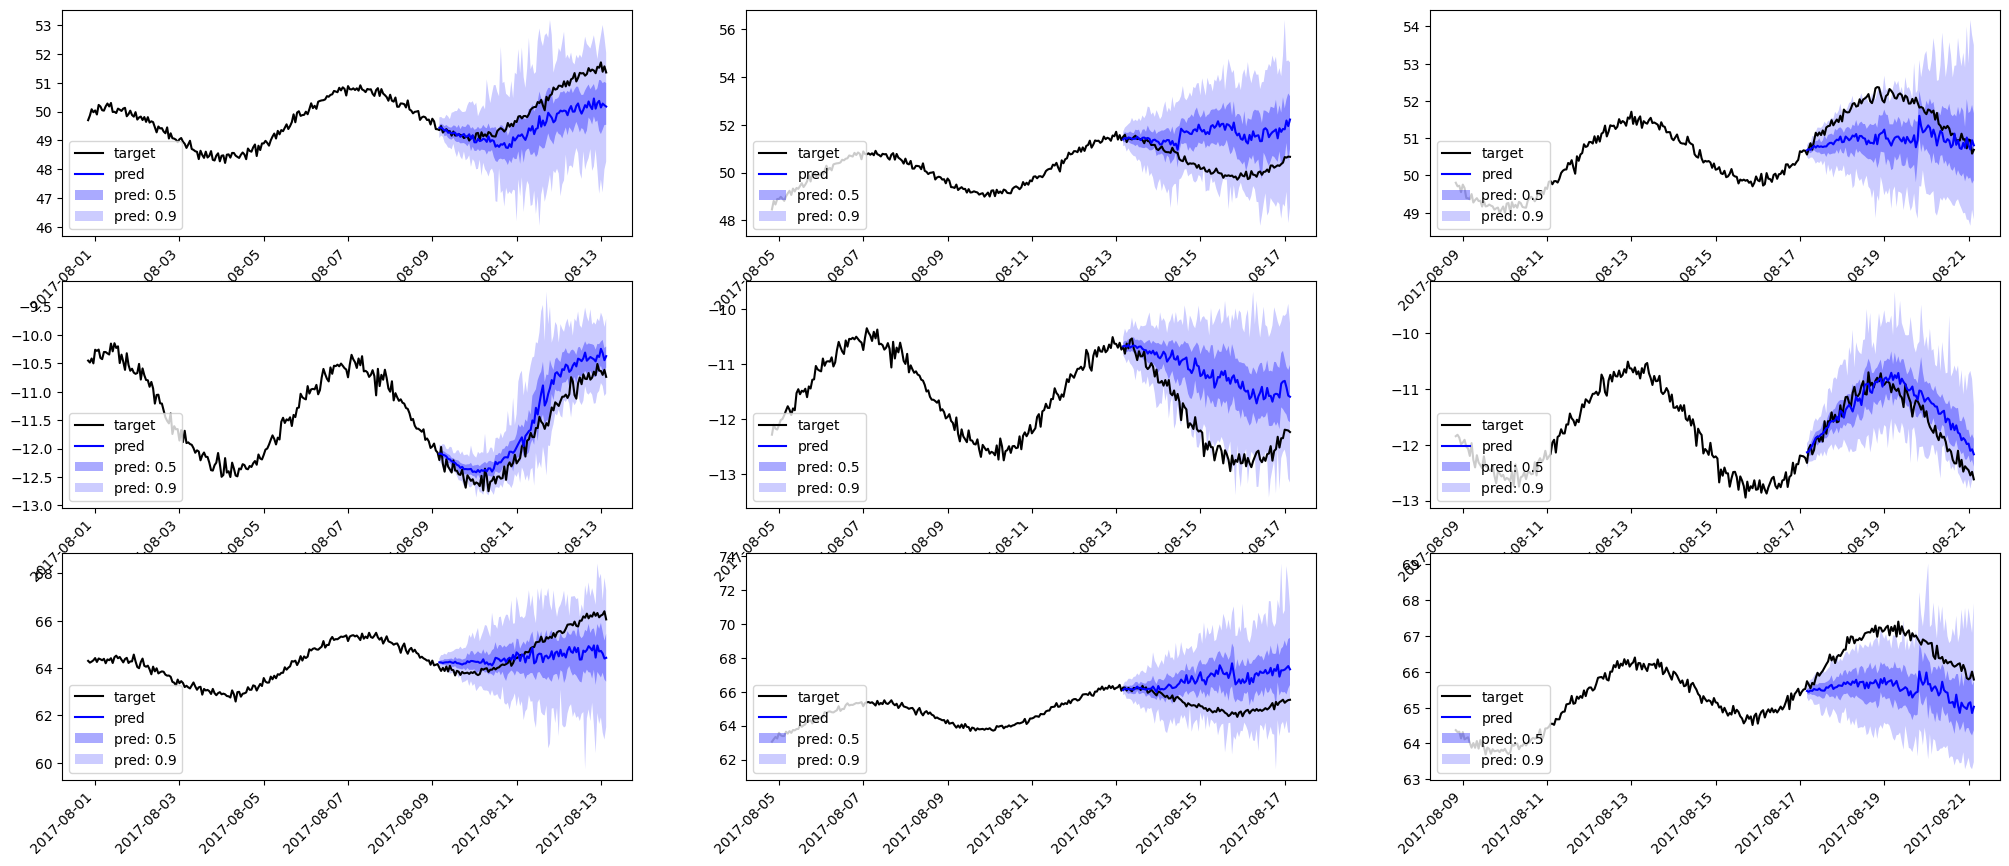

In [30]:
analyze(ds, 10, 512, 96, params, stdev, poly)

# Experiment 5b (Linear with std_dev = 0.05)

In [31]:
params = [(1.0, 0.04436910153386965, 0.6136919916460806, 1.8423302651215687)] * 10  # Sine function parameters: A, k, p, b
stdev = [0.1] * 10

degree = 1                           # Polynomial degree
seed = 42                            # Seed for reproducibility

poly = generate_polynomials(1, 10, 0.05, seed)
df = generate_df(start_date, params, stdev, poly)


print(df)
ds = PandasDataset(dict(df))

                        column1    column2     column3     column4  \
2016-07-01 00:00:00    2.371878   2.510414    2.498515    2.391290   
2016-07-01 01:00:00    2.432177   2.532142    2.531108    2.357791   
2016-07-01 02:00:00    2.562272   2.342999    2.494551    2.525434   
2016-07-01 03:00:00    2.404803   2.454289    2.514142    2.709784   
2016-07-01 04:00:00    2.480356   2.608151    2.735340    2.548789   
...                         ...        ...         ...         ...   
2017-08-21 11:00:00  249.098767 -68.220030  324.694733  762.071247   
2017-08-21 12:00:00  249.282281 -68.379941  324.521264  761.953003   
2017-08-21 13:00:00  249.112167 -68.047784  324.617709  762.298297   
2017-08-21 14:00:00  249.115546 -68.248576  324.680041  762.381022   
2017-08-21 15:00:00  249.294011 -68.028638  324.665575  762.135576   

                        column5     column6     column7     column8  \
2016-07-01 00:00:00    2.313891    2.394017    2.320590    2.386737   
2016-07-01 01:00:

Average MSE:
2.973972218396524
Average MAE
1.3456633990258688

Column 4:
Sine parameters, noise, Poly noise
(1.0, 0.04436910153386965, 0.6136919916460806, 1.8423302651215687)
0.1
(0.07615149282040128,)
Errors
5.482327990918002
1.8673172525795116
------------------------
Column 7:
Sine parameters, noise, Poly noise
(1.0, 0.04436910153386965, 0.6136919916460806, 1.8423302651215687)
0.1
(0.07896064077536957,)
Errors
4.673968113894947
1.6882809267390428
------------------------
Column 8:
Sine parameters, noise, Poly noise
(1.0, 0.04436910153386965, 0.6136919916460806, 1.8423302651215687)
0.1
(0.03837173645764544,)
Errors
3.1807035062042623
1.4891249255033738
------------------------
Column 10:
Sine parameters, noise, Poly noise
(1.0, 0.04436910153386965, 0.6136919916460806, 1.8423302651215687)
0.1
(0.027128002179298234,)
Errors
2.9833116983337997
1.465087050087438
------------------------
Column 1:
Sine parameters, noise, Poly noise
(1.0, 0.04436910153386965, 0.6136919916460806, 1.84233026

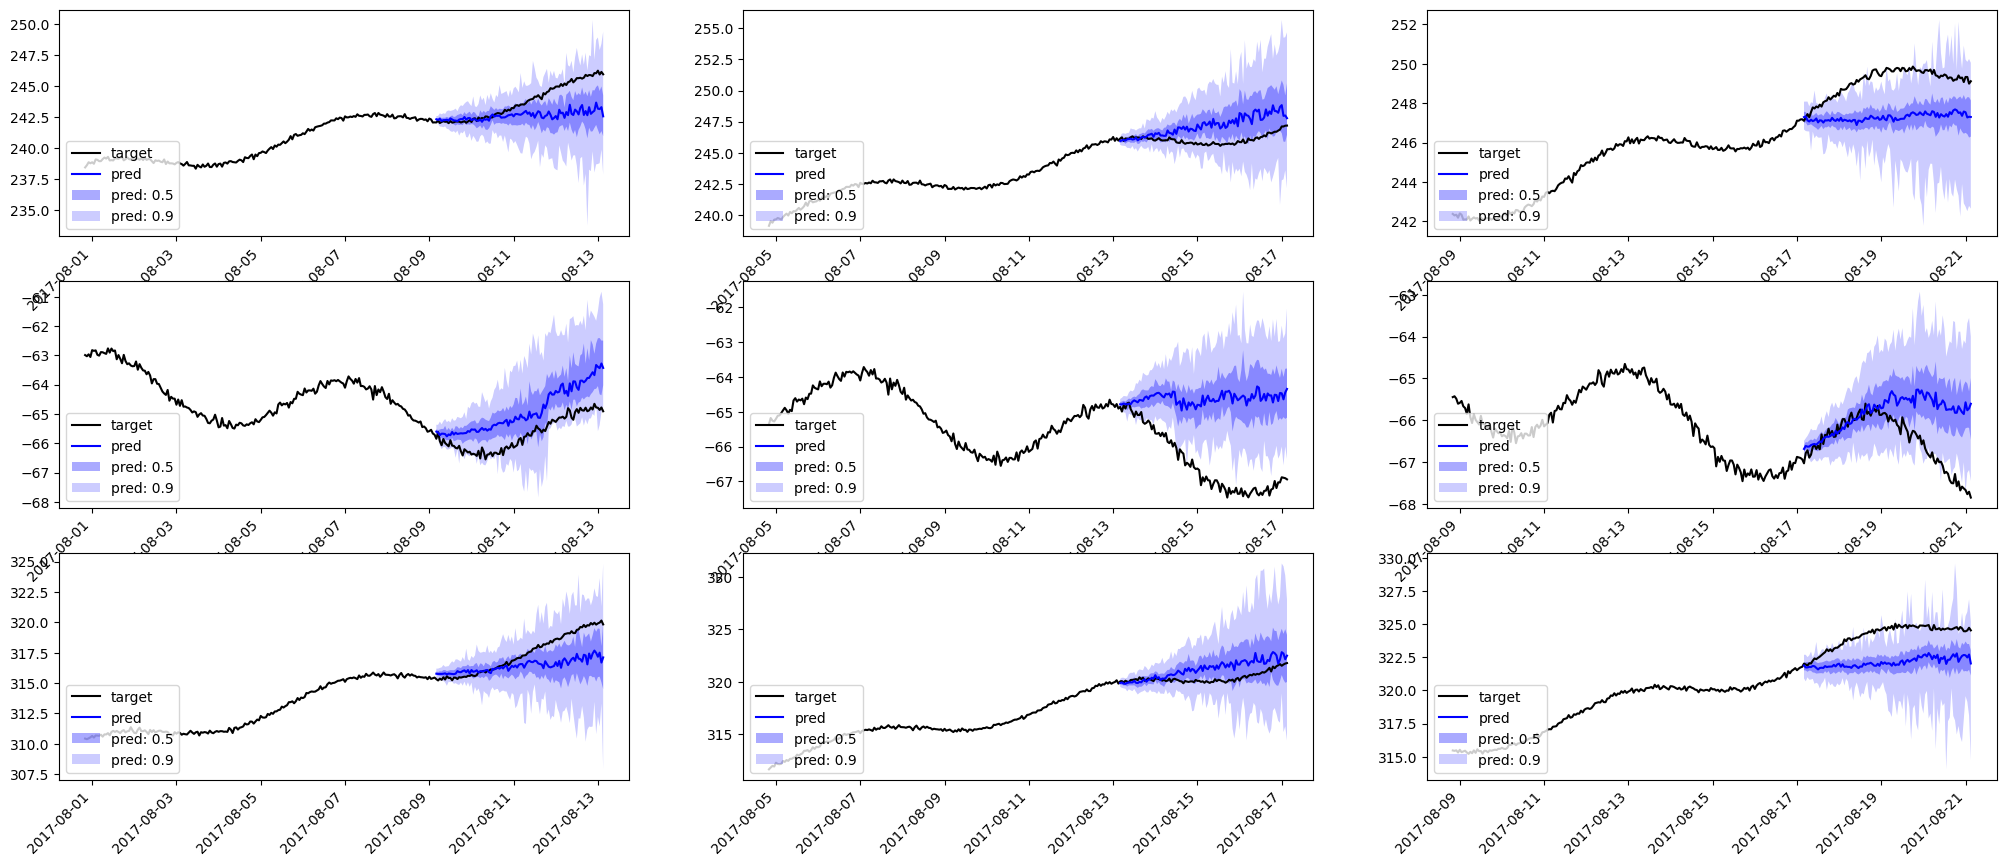

In [32]:
analyze(ds, 10, 512, 96, params, stdev, poly)

# Experiment 6 (Quadratic)

In [33]:
params = [(1.0, 0.04436910153386965, 0.6136919916460806, 1.8423302651215687)] * 10  # Sine function parameters: A, k, p, b
stdev = [0.1] * 10

degree = 1                           # Polynomial degree
seed = 42                            # Seed for reproducibility

poly = generate_polynomials(2, 10, 0.000005, seed)
df = generate_df(start_date, params, stdev, poly)


print(df)
ds = PandasDataset(dict(df))

                       column1     column2     column3     column4  \
2016-07-01 00:00:00   2.564785    2.572704    2.639548    2.518275   
2016-07-01 01:00:00   2.431338    2.514335    2.474411    2.528246   
2016-07-01 02:00:00   2.495160    2.624542    2.503292    2.457540   
2016-07-01 03:00:00   2.379150    2.528181    2.487978    2.479506   
2016-07-01 04:00:00   2.499066    2.630184    2.460033    2.663322   
...                        ...         ...         ...         ...   
2017-08-21 11:00:00 -68.091085  761.721793 -115.956104  384.252567   
2017-08-21 12:00:00 -68.234934  761.728748 -116.199348  384.394405   
2017-08-21 13:00:00 -68.112253  761.846541 -116.033503  384.571313   
2017-08-21 14:00:00 -68.258247  762.039764 -116.080566  384.534174   
2017-08-21 15:00:00 -68.034128  762.457022 -116.231231  384.660517   

                        column5     column6     column7     column8  \
2016-07-01 00:00:00    2.594791    2.360662    2.583617    2.399674   
2016-07-01 01:00:

Average MSE:
6.684530141644886
Average MAE
1.8197352356064833

Column 7:
Sine parameters, noise, Poly noise
(1.0, 0.04436910153386965, 0.6136919916460806, 1.8423302651215687)
0.1
(1.2098113578301707e-06, -9.566401223288991e-06)
Errors
16.162124720070825
2.81367327163384
------------------------
Column 2:
Sine parameters, noise, Poly noise
(1.0, 0.04436910153386965, 0.6136919916460806, 1.8423302651215687)
0.1
(3.2384426905034627e-06, 7.615149282040127e-06)
Errors
11.299114564402489
2.481040043239491
------------------------
Column 10:
Sine parameters, noise, Poly noise
(1.0, 0.04436910153386965, 0.6136919916460806, 1.8423302651215687)
0.1
(-4.540120377606055e-06, -7.061518506676458e-06)
Errors
10.74333740781839
2.22053369207565
------------------------
Column 8:
Sine parameters, noise, Poly noise
(1.0, 0.04436910153386965, 0.6136919916460806, 1.8423302651215687)
0.1
(-8.624589162565164e-06, -2.8114376462048637e-06)
Errors
5.898295799122764
1.7883623790393626
------------------------
Col

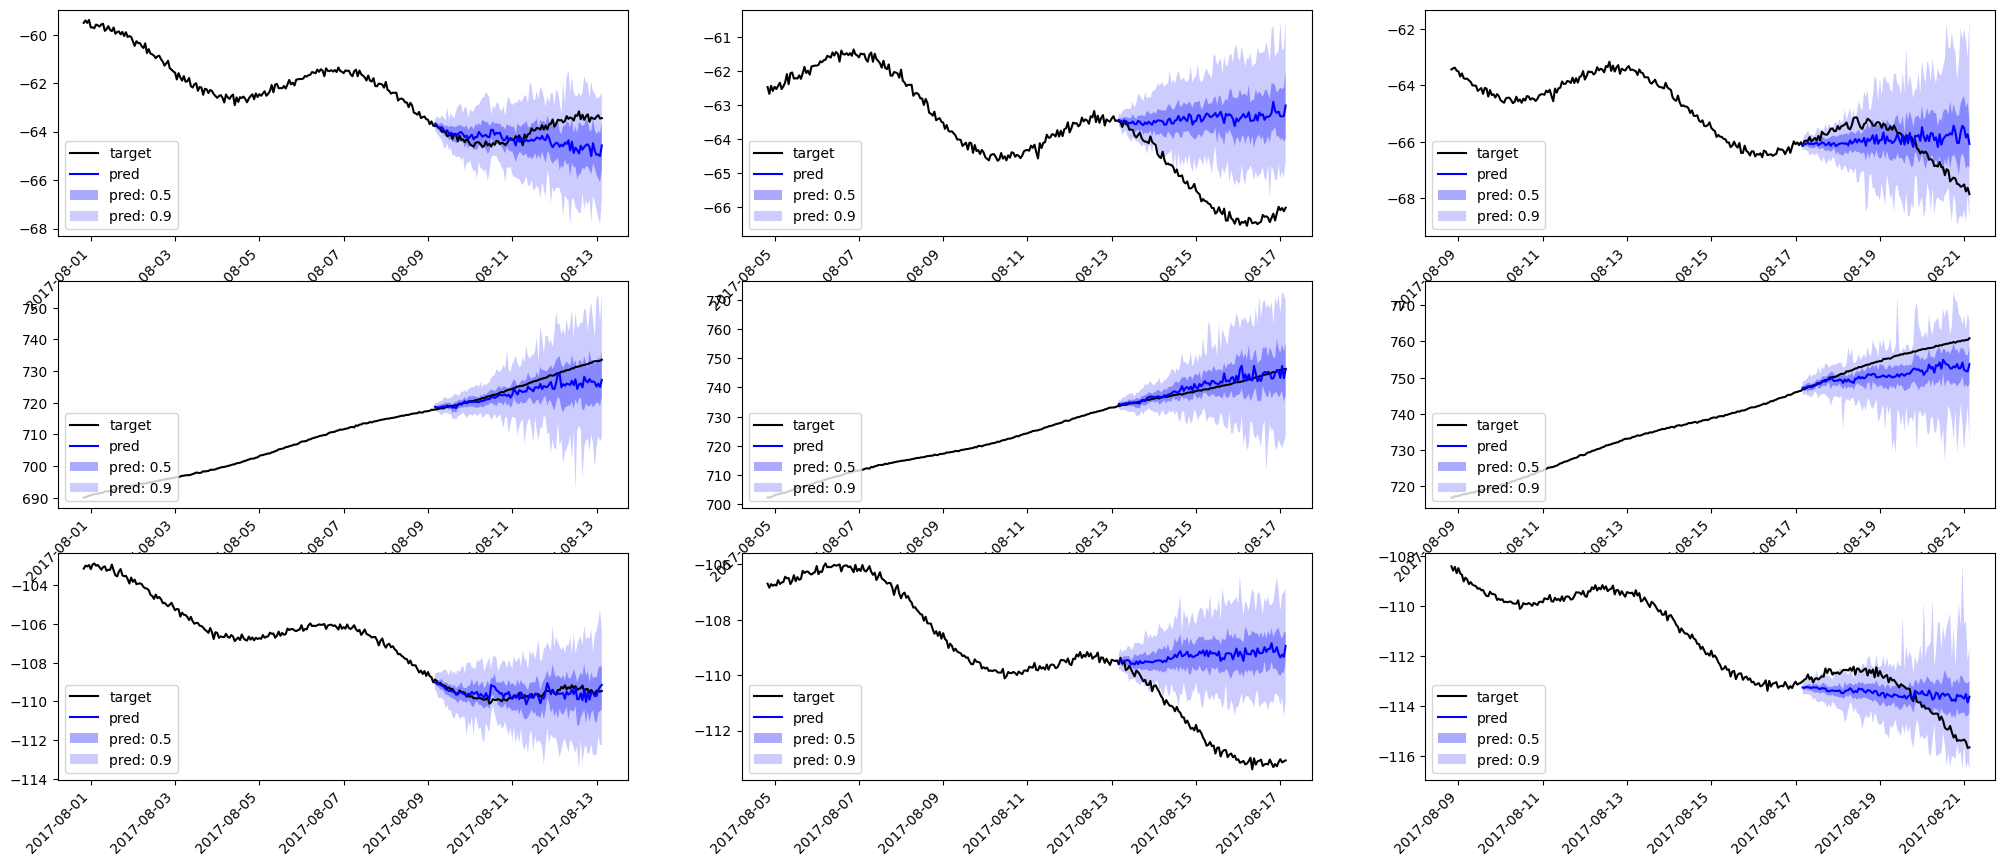

In [34]:
analyze(ds, 10, 512, 96, params, stdev, poly)

# Experiment 7 (Random Sampling in neighborhood of Worst Case)

In [35]:
import numpy as np
def distribution(num_samples: int, means: tuple, std_devs: tuple, seed: int = None) -> list:
    # Set the seed if provided
    if seed is not None:
        np.random.seed(seed)
    
    # Ensure means and std_devs have the same length
    if len(means) != len(std_devs):
        raise ValueError("Means and standard deviations must have the same length.")
    
    # Generate the parameters
    parameters = []
    for _ in range(num_samples):
        # Draw each parameter from its respective normal distribution
        params = tuple(np.random.normal(mean, std_dev) for mean, std_dev in zip(means, std_devs))
        parameters.append(params)
    
    return parameters

Average MSE:
0.6980095517067958
Average MAE
0.6724468301279274

(***************** Worst Case Columns *****************)
Column 6:
Sine parameters, noise, Poly noise
(1.1465648768921555, 0.030482179950703743, 1.8491046041852115, -1.4788563856844286)
Errors
1.4275229758057002
1.003364419456199
------------------------
Column 27:
Sine parameters, noise, Poly noise
(0.9838714288333991, 0.032371661422606966, 2.212836143489733, -1.318923785779899)
Errors
1.1876820832276709
0.897321074873117
------------------------
Column 2:
Sine parameters, noise, Poly noise
(0.9765846625276664, 0.03045709798131581, 2.151441526349105, -1.259638094147792)
Errors
1.115641211848801
0.9109806473336747
------------------------
Column 18:
Sine parameters, noise, Poly noise
(1.0361636025047634, 0.029224149588347976, 1.9078780843493097, -1.182577910416486)
Errors
1.0826934592120034
0.9225545147339576
------------------------
Column 16:
Sine parameters, noise, Poly noise
(0.952082576215471, 0.030602531922171897, 1.

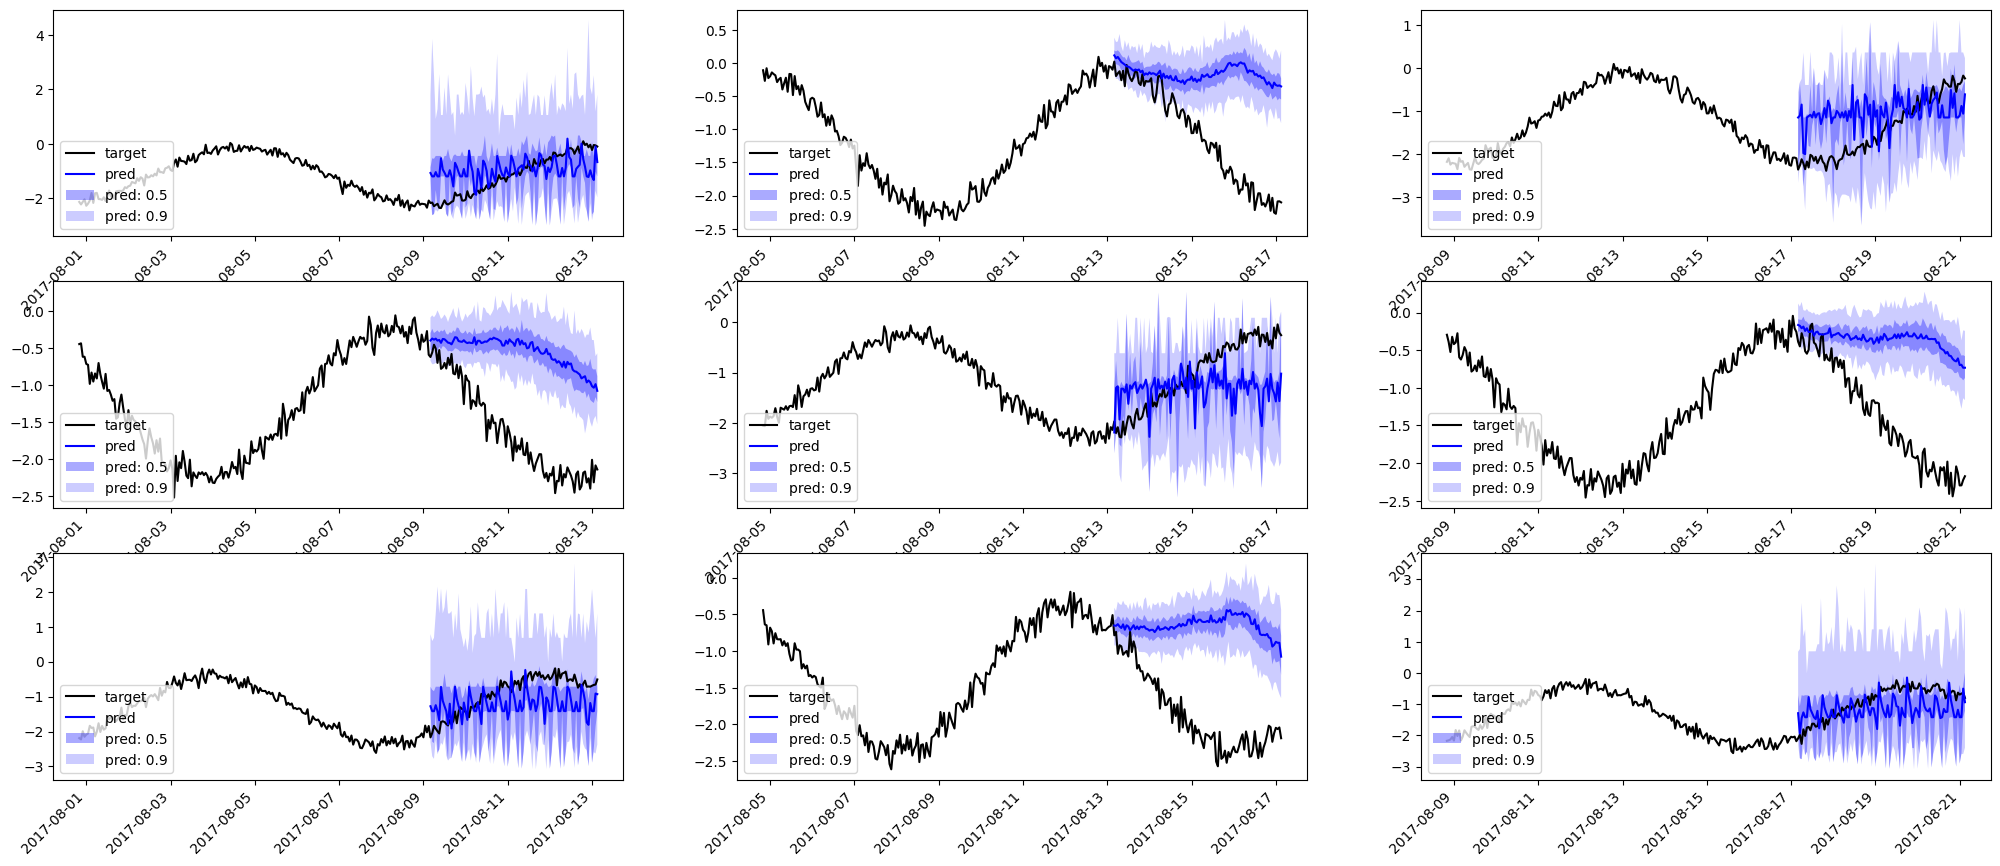

In [49]:
#WORST CASE

# 1.0, 0.03115950885216335, 1.8355989632476268, -1.336381567063083 (Parameters)
# 1.382507271513467 (MSE)
# 1.0399518957956142 (MAE)

means = (1.0, 0.03115950885216335, 1.8355989632476268, -1.336381567063083)
std_devs = (0.1, 0.003, 0.2, 0.1)



params = distribution(30, means, std_devs, 42)
start_date = "2016-07-01 00:00:00"
error = 1.382507271513467 ** (0.5)
#Add noise equal to error
df = generate_df(start_date, params, [error * 0.1] * 30)
ds = PandasDataset(dict(df))

analyze(ds, 30, 512, 96, params)
